In [1]:
# Basic Libraries
import sys
import time
import gc
import random
import copy 
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")

import networks as nets  # Contains RNNs
import net_helpers
import mpn_tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
print(torch.__version__)

2.5.1


In [3]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', 'x', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]

In [4]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict = {}

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygofamily' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
# inputadd, Wfix, WL2, hL2
# inputrandom, Wtrain
# noise001
# largeregularization
# trainetalambda

mpn_depth = 1
n_hidden = 200

hyp_dict['addon_name'] = "reg1e2_noproj"
hyp_dict['addon_name'] += f"+hidden{n_hidden}"

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': False, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False,
        'label_strength': False, 
        'long_delay': 'normal',
        'long_response': 'normal',
        'long_stimulus': 'normal', 
        'long_fixation': 'normal', 
        'adjust_task_prop': True,
        'adjust_task_decay': 0.9, 
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 128,
        'batch_size': 128,
        'gradient_clip': 10,
        'valid_n_batch': 60,
        'n_datasets': 5000, # Number of distinct batches
        'valid_check': None, 
        'n_epochs_per_set': 1, # longer/shorter training
        'weight_reg': 'L2',
        'activity_reg': 'L2', 
        'reg_lambda': 1e-2,

        'scheduler': {
            'type': 'ReduceLROnPlateau',  # or 'StepLR'
            'mode': 'min',                # for ReduceLROnPlateau
            'factor': 0.5,                # factor to reduce LR
            'patience': 10,                # epochs to wait before reducing LR
            'min_lr': 1e-8,
            'step_size': 30,              # for StepLR (step every 30 datasets)
            'gamma': 0.1                  # for StepLR (multiply LR by 0.1)
        },
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'linear_embed': 200, 
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': train_params["n_epochs_per_set"],
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': False, 
        'input_layer_add_trainable': True, # revise this is effectively to [randomize_inputs], tune this
        'input_init_type': "xavier", 
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        'acc_measure': 'stimulus', 
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_activation': 'linear', 
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': False,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 4000, # ms, sets lambda
            'lam_train': False,
            'W_freeze': False, # different combination with [input_layer_add_trainable]
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # Ensure the two options are *not* activated at the same time
    assert not (task_params["randomize_inputs"] and net_params["input_layer_add"]), (
        "task_params['randomize_inputs'] and net_params['input_layer_add'] cannot both be True."
    )

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = mpn_tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = mpn_tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 530
Fixation_off: False; Task_info: True
Rules: ['delaygo', 'delayanti']
  Input size 7, Output size 3
Using CUDA...


In [5]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [6]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim" # or "resp" 

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = mpn_tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix
    )
    _, test_trials, test_rule_idxs = test_trials_extra

    # generate test input data with separate period extension to obtain fixed points information
    task_params_longdelay = copy.deepcopy(task_params)
    task_params_longdelay["long_delay"] = "long"
    test_data_longdelay, test_trials_extra_longdelay = mpn_tasks.generate_trials_wrap(task_params_longdelay, test_n_batch, \
                                                                                      rules=task_params_longdelay['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longdelay, test_rule_idxs_longdelay = test_trials_extra_longdelay

    task_params_longresponse = copy.deepcopy(task_params)
    task_params_longresponse["long_response"] = "long"
    test_data_longresponse, test_trials_extra_longresponse = mpn_tasks.generate_trials_wrap(task_params_longresponse, test_n_batch, \
                                                                                      rules=task_params_longresponse['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longresponse, test_rule_idxs_longresponse = test_trials_extra_longresponse

    task_params_longstimulus = copy.deepcopy(task_params)
    task_params_longstimulus["long_stimulus"] = "long"
    test_data_longstimulus, test_trials_extra_longstimulus = mpn_tasks.generate_trials_wrap(task_params_longstimulus, test_n_batch, \
                                                                                      rules=task_params_longstimulus['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longstimulus, test_rule_idxs_longstimulus = test_trials_extra_longstimulus

    task_params_longfixation = copy.deepcopy(task_params)
    task_params_longfixation["long_fixation"] = "long"
    test_data_longfixation, test_trials_extra_longfixation = mpn_tasks.generate_trials_wrap(task_params_longfixation, test_n_batch, \
                                                                                      rules=task_params_longfixation['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longfixation, test_rule_idxs_longfixation = test_trials_extra_longfixation
    

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    def generate_response_stimulus(task_params, test_trials): 
        """
        """
        labels_resp, labels_stim = [], []
        for rule_idx, rule in enumerate(task_params['rules']):
            print(rule)
            if rule in accept_rules:
                if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                    labels.append(test_trials[rule_idx].meta['matches'])
                else:
                    labels_resp.append(test_trials[rule_idx].meta['resp1'])
                    labels_stim.append(test_trials[rule_idx].meta['stim1']) 
    
            else:
                raise NotImplementedError()
                
        labels_resp = np.concatenate(labels_resp, axis=0).reshape(-1,1)
        labels_stim = np.concatenate(labels_stim, axis=0).reshape(-1,1)

        return labels_resp, labels_stim

    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)

labels = labels_stim if color_by == "stim" else labels_resp
    
test_input, test_output, test_mask = test_data
test_input_longfixation, test_output_longfixation, test_mask_longfixation = test_data_longfixation
test_input_longstimulus, test_output_longstimulus, test_mask_longstimulus = test_data_longstimulus
test_input_longdelay, test_output_longdelay, test_mask_longdelay = test_data_longdelay
test_input_longresponse, test_output_longresponse, test_mask_longresponse = test_data_longresponse

print(f"test_input_longdelay.shape: {test_input_longdelay.shape}")
print(f"test_output_longdelay.shape: {test_output_longdelay.shape}")
print(f"test_input_longresponse.shape: {test_input_longresponse.shape}")
print(f"test_output_longresponse.shape: {test_output_longresponse.shape}")
print(f"test_input_longstimulus.shape: {test_input_longstimulus.shape}")
print(f"test_output_longstimulus.shape: {test_output_longstimulus.shape}")

# permutation = np.random.permutation(test_input.shape[0])
# test_input = test_input[permutation]
# test_output = test_output[permutation]
# test_mask = test_mask[permutation]
# labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

# Total number of batches, might be different than test_n_batch
# this should be the same regardless of variety of test_input
n_batch_all = test_input_np.shape[0] 


test_task = helper.find_task(task_params, test_input_np, shift_index)
test_task_longfixation = helper.find_task(task_params_longfixation, test_input_longfixation.detach().cpu().numpy(), shift_index)
test_task_longstimulus = helper.find_task(task_params_longstimulus, test_input_longstimulus.detach().cpu().numpy(), shift_index)
test_task_longdelay = helper.find_task(task_params_longdelay, test_input_longdelay.detach().cpu().numpy(), shift_index)
test_task_longresponse = helper.find_task(task_params_longresponse, test_input_longresponse.detach().cpu().numpy(), shift_index)

Align ['delaygo', 'delayanti'] With Same Time
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
rng reset with seed 4738
delaygo
delayanti
test_input_longdelay.shape: torch.Size([120, 297, 7])
test_output_longdelay.shape: torch.Size([120, 297, 3])
test_input_longresponse.shape: torch.Size([120, 295, 7])
test_output_longresponse.shape: torch.Size([120, 295, 3])
test_input_longstimulus.shape: torch.Size([120, 297, 7])
test_output_longstimulus.shape: torch.Size([120, 297, 3])


In [7]:
# we use net at different training stage on the same test_input
start_time = time.time()
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst,\
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst), _ = net_helpers.train_network(params, device=device, verbose=verbose,
                                                                                              train=train, hyp_dict=hyp_dict,
                                                                                              netFunction=netFunction,
                                                                                              test_input=[test_input, 
                                                                                                          test_input_longfixation,
                                                                                                          test_input_longstimulus, 
                                                                                                          test_input_longdelay,
                                                                                                          test_input_longresponse],
                                                                                              print_frequency=100)

end_time = time.time()
print(f"Running Time: {end_time - start_time}")
counter_lst = [x * epoch_multiply + 1 for x in counter_lst] # avoid log plot issue    

[7, 200, 3]
MultiPlastic Net:
  output neurons: 3
  Act: tanh

40
  MP Layer0 parameters:
    n_neurons - input: 7, output: 200
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (fixed) // Lambda: scalar (fixed) // Lambda_max: 0.99 (tau: 4.0e+03)
  No Hidden Recurrency.
Trainable parameters: 2,200
W_output: (3, 200)
mp_layer0.W: (200, 7)
mp_layer0.b: (200,)
task_params['rules_probs']: [0.5 0.5]
Rule: delayanti
Rule delayanti seq_len 106, max_seq_len 106
inputs_all paddled: (128, 106, 7)
inputs_all: torch.Size([128, 106, 7])
========== Setup Parameters ==========
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: L2, coef: 1.0e-02
Activity reg: L2, coef: 1.0e-02


/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


valid_acc_history: [None, None, None, None]
Iter: 100, LR: 1.000e-03 - train_loss:1.834e-01, rounded train_acc:0.000, valid_loss:1.736e-01, rounded valid_acc:0.000
task_params['rules_probs']: [0.5 0.5]
Rule: delaygo
Rule delaygo seq_len 103, max_seq_len 103
inputs_all paddled: (128, 103, 7)
inputs_all: torch.Size([128, 103, 7])
valid_acc_history: [None, None, None, None]
Iter: 200, LR: 1.000e-03 - train_loss:1.163e-01, rounded train_acc:0.000, valid_loss:1.157e-01, rounded valid_acc:0.000
task_params['rules_probs']: [0.5 0.5]
Rule: delaygo
Rule delaygo seq_len 106, max_seq_len 106
inputs_all paddled: (128, 106, 7)
inputs_all: torch.Size([128, 106, 7])
valid_acc_history: [None, None, None, None]
Iter: 300, LR: 1.000e-03 - train_loss:9.005e-02, rounded train_acc:0.081, valid_loss:8.393e-02, rounded valid_acc:0.117
task_params['rules_probs']: [0.49126264 0.50873736]
Rule: delaygo
Rule delaygo seq_len 105, max_seq_len 105
inputs_all paddled: (128, 105, 7)
inputs_all: torch.Size([128, 105, 

In [8]:
if hyp_dict['chosen_network'] == "dmpn":
    if net_params["input_layer_add"]:
        fignorm, axsnorm = plt.subplots(1,1,figsize=(4,4))
        axsnorm.plot(counter_lst, [np.linalg.norm(Winput_matrix) for Winput_matrix in Winput_lst], "-o")
        axsnorm.set_xscale("log")
        axsnorm.set_ylabel("Frobenius Norm")

In [9]:
if net_params["input_layer_add"]:
    Win_end = Winput_lst[-1]
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    sns.heatmap(Win_end, ax=ax, center=0, cmap="coolwarm")

In [10]:
# sanity check, if W_freeze, then the recorded W matrix for the modulation layer should not be changed
if net_params["ml_params"]["W_freeze"]: 
    assert np.allclose(Wall_lst[-1][0], Wall_lst[0][0])

if net_params["input_layer_bias"]: 
    assert net_params["input_layer_add"] is True 

Done!


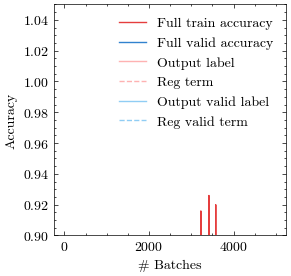

In [11]:
if train:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
    ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    # ax.set_yscale('log')
    ax.legend()
    ax.set_ylim([0.90, 1.05])
    # ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# Batches')
    plt.savefig(f"./twotasks/loss_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
    
print('Done!')

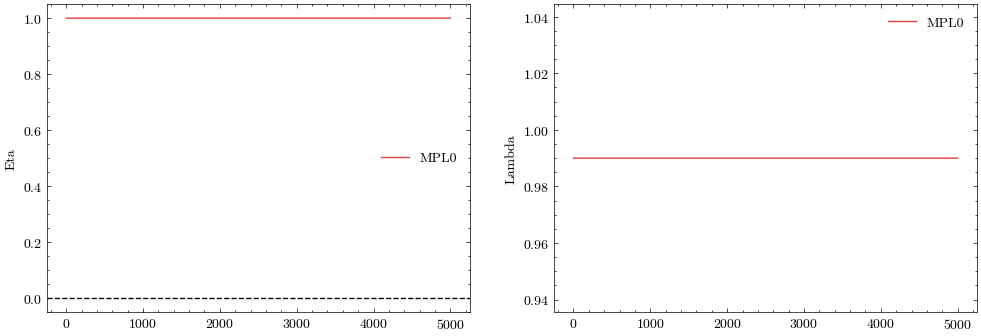

In [12]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

In [13]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    # ind = len(marker_lst)-1 
    ind = -1
    # network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    # print(f"Using network at {network_at_percent}%")
    # by default using the first test_input 
    net_out = netout_lst[0][ind]
    db = db_lst[0][ind]
    # W_output = Woutput_lst[ind]
    # W_ = Wall_lst[ind][0]

In [14]:
def plot_input_output(test_input_np, net_out, test_output_np, test_task=None, tag="", batch_num=5, label=None):
    """
    """
    test_input_np = helper.to_ndarray(test_input_np)
    net_out = helper.to_ndarray(net_out)
    test_output_np = helper.to_ndarray(test_output_np)
    
    fig_all, axs_all = plt.subplots(batch_num,2,figsize=(4*2,batch_num*2))
    
    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])
    
    else:
        for batch_idx in range(batch_num):
            for out_idx in range(test_output_np.shape[-1]):
                axs_all[batch_idx,0].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx], label=out_idx)
                axs_all[batch_idx,0].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                if test_task is not None: 
                    outname = f"{task_params['rules'][test_task[batch_idx]]}; {tag}"
                    axs_all[batch_idx,0].set_title(outname)
                axs_all[batch_idx,0].legend()
    
            input_batch = test_input_np[batch_idx,:,:]
            if task_params["randomize_inputs"]: 
                input_batch = input_batch @ np.linalg.pinv(task_params["randomize_matrix"])
            for inp_idx in range(input_batch.shape[-1]):
                axs_all[batch_idx,1].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                if test_task is not None: 
                    axs_all[batch_idx,1].set_title(f"{task_params['rules'][test_task[batch_idx]]}; {tag}")
                axs_all[batch_idx,1].legend()

    for ax in axs_all.flatten(): 
        ax.set_ylim([-2, 2])
    fig_all.tight_layout()
    fig_all.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_seed{seed}_{hyp_dict['addon_name']}_{tag}.png", dpi=300)

    return fig_all, axs_all

(<Figure size 800x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>]], dtype=object))

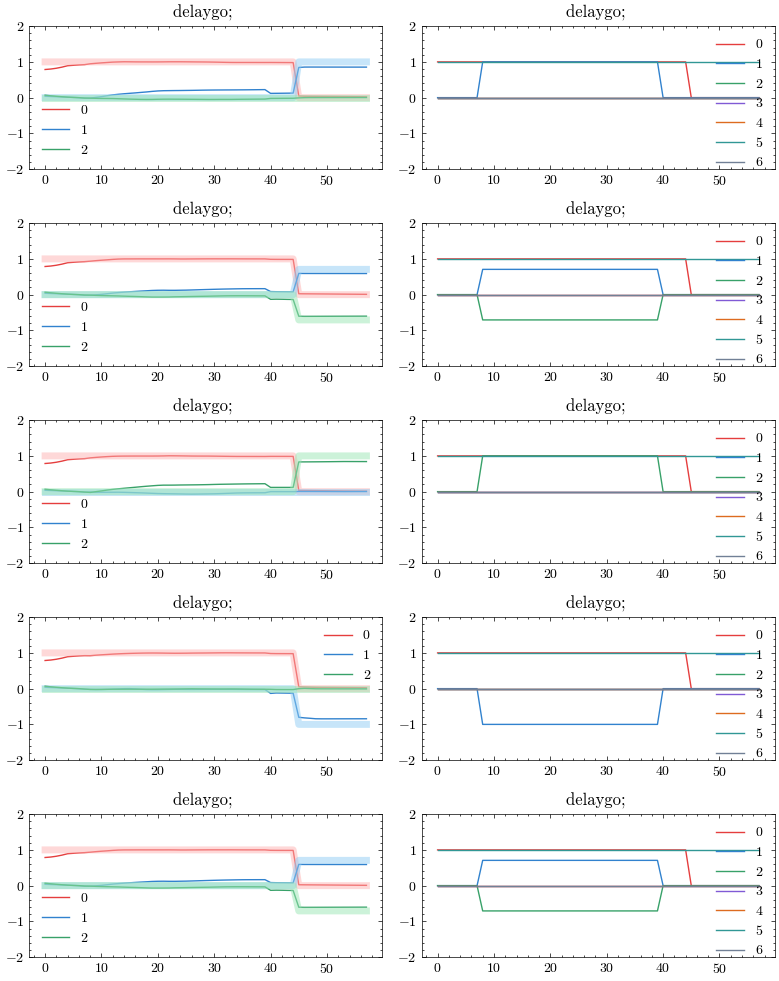

In [15]:
plot_input_output(test_input_np, net_out, test_output_np, test_task, tag="")

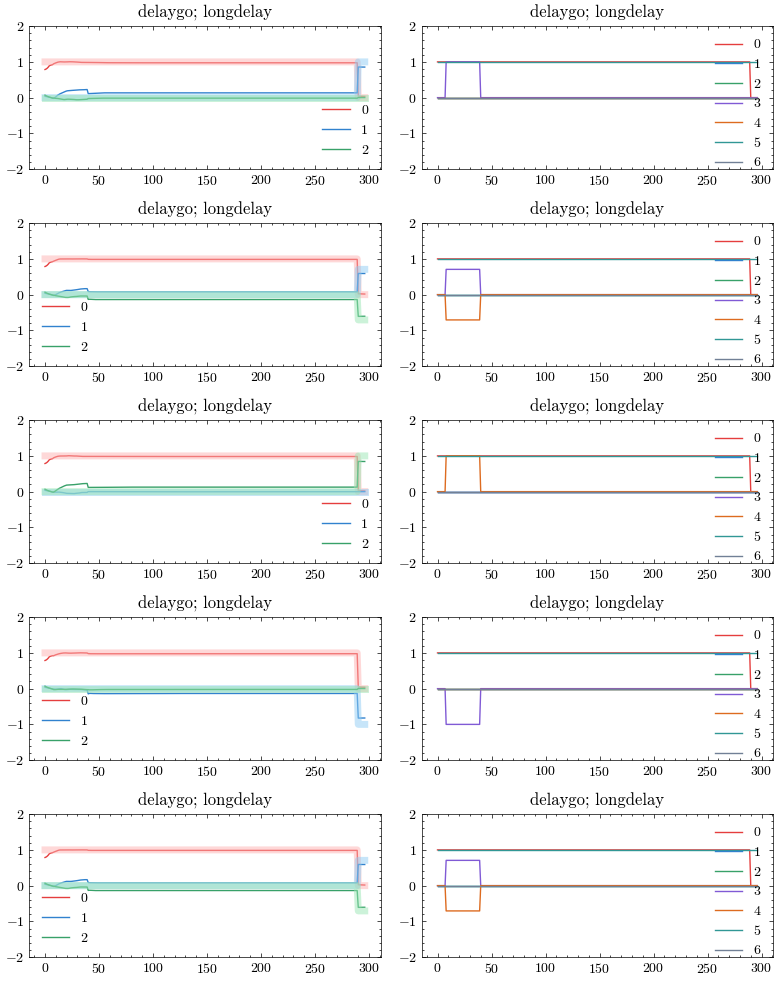

In [16]:
figld, axsld = plot_input_output(test_input_longdelay, netout_lst[3][ind], test_output_longdelay, 
                                 test_task_longdelay, tag="longdelay")

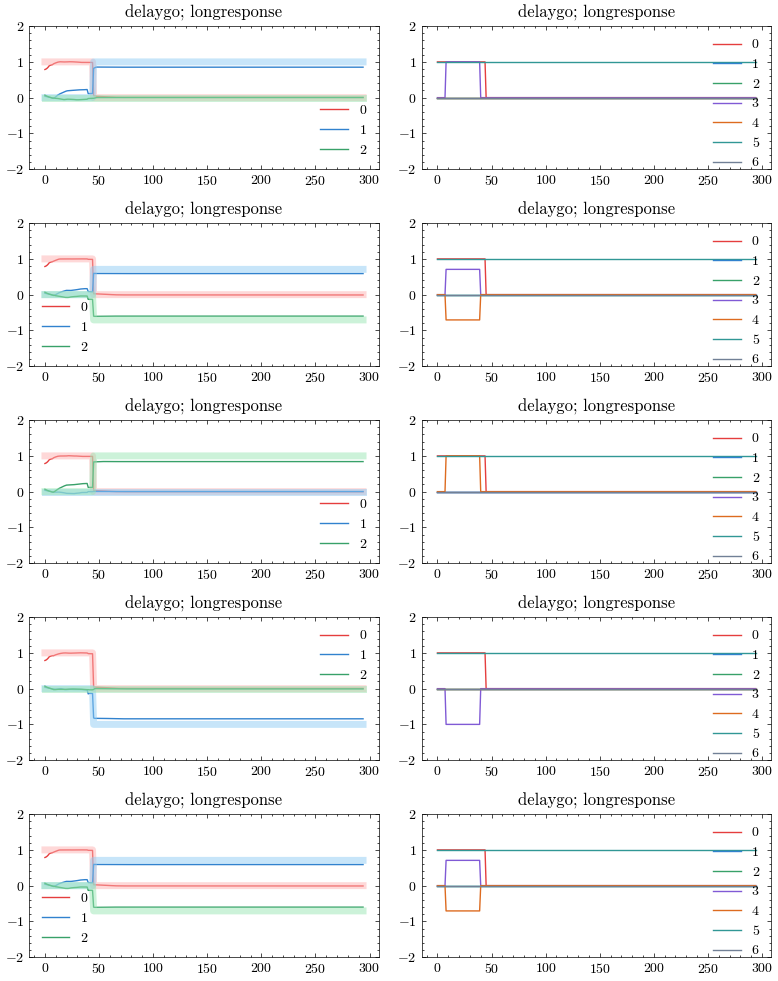

In [17]:
figlr, axslr = plot_input_output(test_input_longresponse, netout_lst[4][ind], test_output_longresponse, 
                                 test_task_longresponse, tag="longresponse")

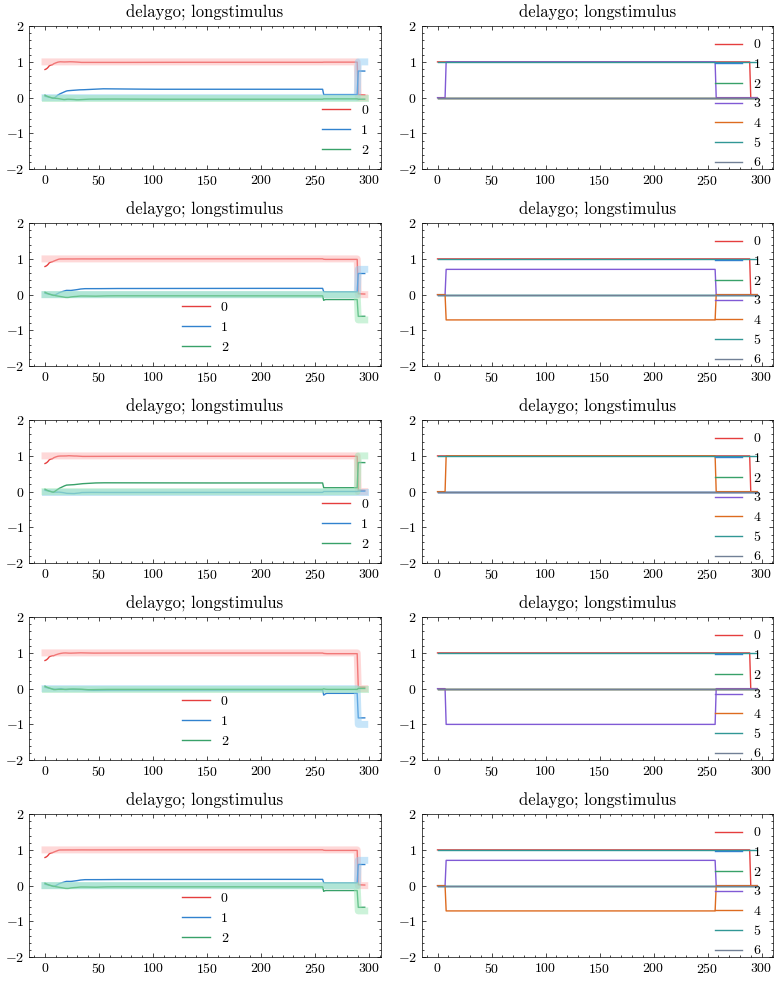

In [18]:
figls, axsls = plot_input_output(test_input_longstimulus, netout_lst[2][ind], test_output_longstimulus, 
                                 test_task_longstimulus, tag="longstimulus")

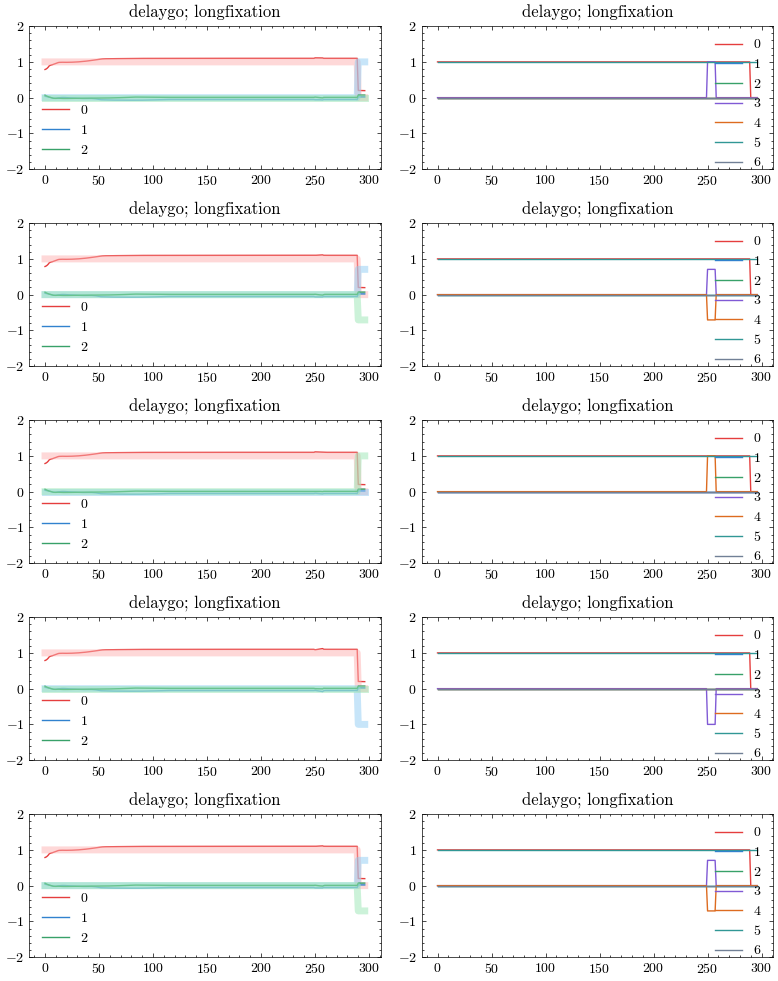

In [19]:
figlf, axslf = plot_input_output(test_input_longfixation, netout_lst[1][ind], test_output_longfixation, 
                                 test_task_longfixation, tag="longfixation")

In [20]:
def dimensionality_measure(W):
    """
    Dimensionality in recurrent spiking networks: Global trends in activity and local origins in
    connectivity (Equation 3)
    "The dimensionality is a weighted measure of the number of axes explored by that cloud"
    Recanatesi, et al., 2019
    return value in range of (0, 1]
    """
    covW = np.cov(W)
    assert covW.shape[0] == n_hidden
    eigenvalues, eigenvectors = np.linalg.eig(covW)
    numerator = np.sum(eigenvalues) ** 2
    denominator = np.sum(eigenvalues ** 2)
    return (numerator / denominator) / W.shape[0]

In [21]:
def make_label_task_comb(task_params, test_trials, test_task, color_by="stim"):
    """
    """
    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)
    labels_ = labels_stim if color_by == "stim" else labels_resp
    # pair: [label_first_dim, task_id] for each trial
    return np.column_stack((labels_[:, 0], test_task))

label_task_comb_longdelay = make_label_task_comb(
    task_params_longdelay, test_trials_longdelay, test_task_longdelay, color_by=color_by
)

label_task_comb_longresponse = make_label_task_comb(
    task_params_longresponse, test_trials_longresponse, test_task_longresponse, color_by=color_by
)

label_task_comb_longstimulus = make_label_task_comb(
    task_params_longstimulus, test_trials_longstimulus, test_task_longstimulus, color_by=color_by
)

label_task_comb_longfixation = make_label_task_comb(
    task_params_longfixation, test_trials_longfixation, test_task_longfixation, color_by=color_by
)

label_task_comb = make_label_task_comb(
    task_params, test_trials, test_task, color_by=color_by
)

delaygo
delayanti
delaygo
delayanti
delaygo
delayanti
delaygo
delayanti
delaygo
delayanti


In [22]:
# here db is selected based on learning stage selection 

layer_index = 0 # 1 layer MPN 
if net_params["input_layer_add"]:
    layer_index += 1 

In [23]:
idx = [i for i in range(len(label_task_comb)) if (label_task_comb[i] == [5, 1]).all()]
[db[f"hidden{layer_index}"][idx_].sum() for idx_ in idx]
# print(db.keys())

[np.float32(430.48767),
 np.float32(430.48767),
 np.float32(430.48767),
 np.float32(430.48767),
 np.float32(430.48767),
 np.float32(430.48767),
 np.float32(430.48767)]

In [24]:
def sample_non_nan(arr, k):
    """
    Pick `k` distinct (non-NaN) numbers from a 2-D NumPy array.
    """
    pool = arr[~np.isnan(arr)]            # flatten & keep only real numbers
    if k > pool.size:                     # ensure enough unique values
        raise ValueError("k exceeds number of non-NaN entries.")
    return np.random.choice(pool, k, replace=False).tolist()


def assert_sums_close(arr_list, rtol=1e-5, atol=1e-8):
    """
    """
    assert len(arr_list) > 0, "Empty list."
    sums = np.array([np.sum(a) for a in arr_list], dtype=float)
    ref = sums[0]
    ok = np.isclose(sums, ref, rtol=rtol, atol=atol)

    if not np.all(ok):
        bad = np.where(~ok)[0]
        raise AssertionError(
            f"Sum mismatch at indices {bad.tolist()}.\n"
            f"ref_sum={ref}, bad_sums={sums[bad].tolist()}, all_sums={sums.tolist()}"
        )


In [25]:
net

DeepMultiPlasticNet(
  (recurrent_weights): ParameterList()
  (mp_layer0): MultiPlasticLayer()
)

In [26]:
def analyze_similarity(Ms_orig, 
                       hs, 
                       net, 
                       net_params, 
                       label_task_comb, 
                       checktime, 
                       compare="modulation", 
                       moddim=0): 
    """
    """
    # print(f"compare: {compare}; moddim: {moddim}")
    inverse_modulation_ss_dt = []
    inverse_modulation_sr_dt = []
    inverse_modulation_st_ds = [[], []]
    modulation_save = [[],[]]
    modulation_save_time = [[],[]]
    hidden_save_time = [[],[]]
    
    if net_params["input_layer_add"]:
        W = net.mp_layer1.W.data.detach().cpu().numpy()
    else:
        W = net.mp_layer0.W.data.detach().cpu().numpy()

    if compare == "w_modulation":
        Ms_orig = Ms_orig * W[None,None,:,:]

    # same stimulus (effectively anti-response), different task
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 1])]
        ll = min(len(ind1), len(ind2))

        if net_params["input_layer_add"]:
            win = net.W_initial_linear.weight.data.detach().cpu().numpy()

        # M @ win: effective plastic sensitivity
        # How does the current memory (M) distort or amplify specific input channels?
        if compare in ("modulation", "w_modulation"):                 
            winadd = False if moddim == None else True
 
            if winadd: 
                if net_params["input_layer_add"]: 
                    if moddim == "Win": 
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                    else:
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                else:
                    if moddim == "Win": 
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:])).flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:])).flatten() for i in range(ll)]
                    else:
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]))[:,moddim].flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]))[:,moddim].flatten() for i in range(ll)]
            else:
                Ms1_change_stimulus = [(Ms_orig[ind1[i],checktime,:,:]).flatten() for i in range(ll)]
                Ms2_change_stimulus = [(Ms_orig[ind2[i],checktime,:,:]).flatten() for i in range(ll)]
                
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]

        # since we group by the same stimulus at the same task
        # the period is aligned in all trials of testing data
        # therefore the resulting modulation & hidden should be identical
        assert_sums_close(Ms1_change_stimulus, rtol=1e-3, atol=1e-3)
        assert_sums_close(Ms2_change_stimulus, rtol=1e-3, atol=1e-3)
        
        inverse_modulation_ss_dt.append(1 - cosine(Ms1_change_stimulus[0], Ms2_change_stimulus[0]))

        modulation_save[0].append(Ms1_change_stimulus[0])
        modulation_save[1].append(Ms2_change_stimulus[0])

        # modulation for one type of stimulus for two tasks
        Ms1_all = Ms_orig[ind1[0],:,:,:]
        Ms2_all = Ms_orig[ind2[0],:,:,:]
        h1_all = hs[ind1[0],:,:]
        h2_all = hs[ind2[0],:,:]
        # save the whole modulation trajectory for this stimulus (go and anti)
        modulation_save_time[0].append(Ms1_all)
        modulation_save_time[1].append(Ms2_all)
        hidden_save_time[0].append(h1_all)
        hidden_save_time[1].append(h2_all)

    # same response, different task 
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [(k + 4) % 8, 1])]
        ll = min(len(ind1), len(ind2))

        if compare in ("modulation", "w_modulation"): 
            winadd = False if moddim == None else True
 
            if winadd: 
                if net_params["input_layer_add"]: 
                    if moddim == "Win": 
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win).flatten() for i in range(ll)]
                    else:
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,moddim].flatten() for i in range(ll)]
                else:
                    if moddim == "Win": 
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:])).flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:])).flatten() for i in range(ll)]
                    else:
                        Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]))[:,moddim].flatten() for i in range(ll)]
                        Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]))[:,moddim].flatten() for i in range(ll)]
            else:
                Ms1_change_stimulus = [(Ms_orig[ind1[i],checktime,:,:]).flatten() for i in range(ll)]
                Ms2_change_stimulus = [(Ms_orig[ind2[i],checktime,:,:]).flatten() for i in range(ll)]
                
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]

        assert_sums_close(Ms1_change_stimulus, rtol=1e-3, atol=1e-3)
        assert_sums_close(Ms2_change_stimulus, rtol=1e-3, atol=1e-3)
        
        inverse_modulation_sr_dt.append(1 - cosine(Ms1_change_stimulus[0], Ms2_change_stimulus[0]))

    # same task, different stimulus 
    repeat = 100
    modulation_matrices_all = [] 
    for _ in range(repeat): 
        modulation_matrices = [
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan), 
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan)
        ]
        
        for i in range(len(modulation_save[0])):
            for j in range(i+1, len(modulation_save[0])):
                modulation_matrices[0][i,j] = 1 - cosine(modulation_save[0][i], modulation_save[0][j])
                modulation_matrices[1][i,j] = 1 - cosine(modulation_save[1][i], modulation_save[1][j])

        try: 
            modulation_matrices_all.append([np.nanmean(sample_non_nan(modulation_matrices[0], 8)),
                                            np.nanmean(sample_non_nan(modulation_matrices[1], 8))])
        except Exception as e:
            modulation_matrices_all.append([np.nan, np.nan])

    modulation_matrices_all = np.array(modulation_matrices_all)

    result = [[np.mean(inverse_modulation_ss_dt), np.std(inverse_modulation_ss_dt)], 
              [np.mean(inverse_modulation_sr_dt), np.std(inverse_modulation_sr_dt)], 
              [np.mean(modulation_matrices_all[:,0]), np.std(modulation_matrices_all[:,0])], 
              [np.mean(modulation_matrices_all[:,1]), np.std(modulation_matrices_all[:,1])]]

    return result, modulation_save_time, hidden_save_time

In [27]:
def modulation_extraction(test_input, db, layer_index, cuda=False):
    """
    Extracts modulation tensors from `db` and returns:
        Ms:      (batch, seq, features) reshaped version of M
        Ms_orig: original M (no reshape)
        hs:      (batch, seq, features) reshaped version of hidden
        bs:      bias vector/matrix as-is (or concatenated if list)
    """

    def _to_numpy(x):
        # Convert torch.Tensor -> numpy, otherwise np.asarray
        try:
            import torch
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
        except Exception:
            pass
        return np.asarray(x)

    def _concat_last(x):
        # If list/tuple of arrays: concatenate on last axis; else return as-is
        return np.concatenate(x, axis=-1) if isinstance(x, (list, tuple)) else x

    n_batch, max_seq_len = test_input.shape[0], test_input.shape[1]

    # M
    M_raw = _concat_last(_to_numpy(db[f"M{layer_index}"]))
    Ms = M_raw.reshape(n_batch, max_seq_len, -1)
    Ms_orig = M_raw  # unreshaped

    # b
    bs = _concat_last(_to_numpy(db[f"b{layer_index}"]))

    # hidden
    H_raw = _concat_last(_to_numpy(db[f"hidden{layer_index}"]))
    hs = H_raw.reshape(n_batch, max_seq_len, -1)

    return Ms, Ms_orig, hs, bs

In [28]:
# across training stage
result_attractor_all_h, result_attractor_all_m, result_attractor_all_wm, result_attractor_all_wmwin = [], [], [], []
modulation_save_time = []
pr_all = [] 
test_input_long_all = [test_input, test_input_longfixation, test_input_longstimulus, 
                       test_input_longdelay, test_input_longresponse]
label_task_comb_long_all = [label_task_comb, label_task_comb_longfixation, label_task_comb_longstimulus, 
                            label_task_comb_longdelay, label_task_comb_longresponse]
# register the timestamps information for different long periods
time_stamps_usual, time_stamps_longfixation, time_stamps_longstimulus, time_stamps, time_stamps_longresponse = {}, {}, {}, {}, {}

for i in range(5): 
    for db_attractor in db_lst[i]:
        _, M_long, h_long, _, = modulation_extraction(test_input_long_all[i], db_attractor, layer_index)
    
        prs = [dimensionality_measure(h_long[i,:,:].T) for i in range(h_long.shape[0])]
        
        if i == 0: 
            pr_all.append([np.mean(prs), np.std(prs)])
        
        # to handle noise, find the time when fixation is off
        checktime_sample = test_input_long_all[i][0,:,0].detach().cpu()
        mask = checktime_sample < 0.5                          
        idx = torch.nonzero(mask, as_tuple=False) 
        checktime_attractor = idx[0].item()  

        if i == 3: 
            time_stamps["delay_end"] = checktime_attractor - 1 # a little bit before the fixation off
        elif i == 4:
            time_stamps_longresponse["delay_end"] = checktime_attractor - 1
        elif i == 0: 
            time_stamps_usual["delay_end"] = checktime_attractor - 1
            cc = time_stamps_usual["delay_end"] 
        elif i == 2: 
            time_stamps_longstimulus["delay_end"] = checktime_attractor - 1
        elif i == 1:
            time_stamps_longfixation["delay_end"] = checktime_attractor - 1

        if i == 0: 
            result_attractor_h, _, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
                                                            checktime=cc, compare="hidden")
            result_attractor_m, m_save, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
                                                            checktime=cc, compare="modulation", moddim=0)
            result_attractor_wm, _, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
                                                           checktime=cc, compare="w_modulation", moddim=None)
            result_attractor_wmwin, _, _ = analyze_similarity(M_long, h_long, net, net_params, label_task_comb_long_all[i], 
                                                            checktime=cc, compare="w_modulation", moddim="Win")
            
            result_attractor_all_h.append(result_attractor_h)
            result_attractor_all_m.append(result_attractor_m)
            result_attractor_all_wm.append(result_attractor_wm)
            result_attractor_all_wmwin.append(result_attractor_wmwin)
            modulation_save_time.append(m_save)

In [29]:
W_out = net.W_output.data.detach().cpu().numpy()
db_lst[0][-1][f"b{layer_index}"].shape

(120, 58, 200)

SystemExit: 

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


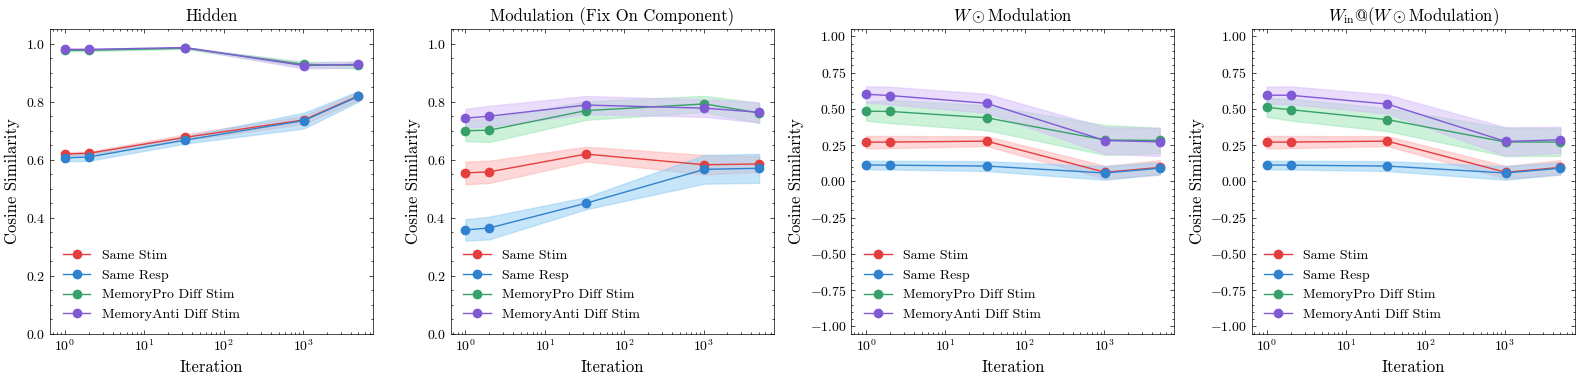

In [30]:
figattractor, axsattractor = plt.subplots(1,4,figsize=(4*4,4))

break_names = [
    "Same Stim",
    "Same Resp",
    "MemoryPro Diff Stim",
    "MemoryAnti Diff Stim",
]

def plot_mean_std(ax, x, mean, std, color, fill_color, label):
    ax.plot(x, mean, "-o", color=color, label=label)
    ax.fill_between(x, np.asarray(mean) - np.asarray(std), np.asarray(mean) + np.asarray(std),
                    alpha=0.5, color=fill_color)

# each entry: (results, axis_index)
panels = [
    (result_attractor_all_h, 0),
    (result_attractor_all_m, 1),
    (result_attractor_all_wm, 2),
    (result_attractor_all_wmwin, 3)
]

n_groups = len(result_attractor_all_h[0])  # same as your original len(result_attractor_all[0])

for i in range(n_groups):
    for results, ax_idx in panels:
        mean = [rs[i][0] for rs in results]
        std  = [rs[i][1] for rs in results]
        plot_mean_std(
            axsattractor[ax_idx],
            counter_lst,
            mean,
            std,
            color=c_vals[i],
            fill_color=c_vals_l[i],
            label=break_names[i],
        )

for ax in axsattractor:
    ax.set_xscale("log")
    ax.legend()
    ax.set_ylabel("Cosine Similarity", fontsize=12)
    ax.set_xlabel("Iteration", fontsize=12)
    
axsattractor[0].set_ylim([0,1.05])
axsattractor[1].set_ylim([0,1.05])
axsattractor[2].set_ylim([-1.05,1.05])
axsattractor[3].set_ylim([-1.05,1.05])
    
axsattractor[0].set_title("Hidden", fontsize=12)
axsattractor[1].set_title("Modulation (Fix On Component)", fontsize=12)
axsattractor[2].set_title("$W \odot \mathrm{Modulation}$", fontsize=12)
axsattractor[3].set_title(r"$W_{\mathrm{in}} @ (W \odot \mathrm{Modulation})$", fontsize=12)

figattractor.tight_layout()
figattractor.savefig(
    f"./twotasks/attractor_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)
sys.exit()

In [ ]:
learning_hm_similarity = {
    "break_names": break_names, 
    "counter_lst": counter_lst, 
    "result_attractor_all_h": result_attractor_all_h, 
    "result_attractor_all_m": result_attractor_all_m,
    "result_attractor_all_wmwin": result_attractor_all_wmwin
}


In [ ]:
print(f"shift_index: {shift_index}")

In [ ]:
# across different timestamp 
def time_stamp_extract(test_input_long, time_stamps):
    stimulus_end = None 
    chosen_batch = 0
    while stimulus_end is None: 
        try: 
            input_part = test_input_long[chosen_batch,:,2-shift_index:2+4-shift_index].detach().cpu().numpy()
            input_part_sum = np.sum(input_part, axis=1)
            stimulus_end = np.where(input_part_sum > 0.5)[0][-1]
            stimulus_start = np.where(input_part_sum > 0.5)[0][0] - 1
        except IndexError: 
            chosen_batch += 1
    
    time_stamps["stimulus_start"] = stimulus_start + 1
    time_stamps["stimulus_end"] = stimulus_end + 1
    time_stamps["delay_start"] = stimulus_end + 1
    time_stamps["trial_end"] = len(input_part_sum) - 1
    time_stamps["fixation_end"] = stimulus_start
    time_stamps["fixation_start"] = 0 

    return time_stamps

time_stamps = time_stamp_extract(test_input_longdelay, time_stamps)
time_stamps_longresponse = time_stamp_extract(test_input_longresponse, time_stamps_longresponse)
time_stamps_usual = time_stamp_extract(test_input, time_stamps_usual)
time_stamps_longstimulus = time_stamp_extract(test_input_longstimulus, time_stamps_longstimulus)
time_stamps_longfixation = time_stamp_extract(test_input_longfixation, time_stamps_longfixation)

print(f"time_stamps: {time_stamps}")
print(f"time_stamps_longresponse: {time_stamps_longresponse}")
print(f"time_stamps_usual: {time_stamps_usual}")
print(f"time_stamps_longstimulus: {time_stamps_longstimulus}")
print(f"time_stamps_longfixation: {time_stamps_longfixation}")

In [ ]:
M_all = db_lst[0][-1][f"M{layer_index}"]

In [ ]:
def input_change(U, X):
    """
    """
    eps = 1e-12
    
    # U: (B, T, 3), X: (B, T, 200) as numpy arrays
    u2 = np.sum(U**2, axis=-1)   # (B, T)
    x2 = np.sum(X**2, axis=-1)   # (B, T)
    
    # A) Global RMS gain (stable)
    g_rms = np.sqrt(x2.mean()) / (np.sqrt(u2.mean()) + eps)
    
    # Per-(b,t) gain distribution
    g_per = np.sqrt(x2) / (np.sqrt(u2) + eps)  # (B, T)
    
    g_median = np.median(g_per)
    g_p10, g_p90 = np.quantile(g_per, [0.10, 0.90])

    return g_rms

In [ ]:
def cosine_sim(a, b):
    return 1.0 - cosine(a, b)

In [ ]:
activity_list = []
for i in range(8):
    mod1_stim1 = m_save[0][i]
    mod2_stim1 = m_save[1][i]
    
    M_all = db_lst[0][-1][f"M{layer_index}"]

    for j in range(M_all.shape[0]):
        if np.sum(np.abs(M_all[j,:,:,:]-mod1_stim1)) <= 1e-3:
            mod1_j = j
        if np.sum(np.abs(M_all[j,:,:,:]-mod2_stim1)) <= 1e-3:
            mod2_j = j

    all_hidden = db_lst[0][-1][f"hidden{layer_index}"]
    hidden1 = all_hidden[mod1_j].T
    hidden2 = all_hidden[mod2_j].T

    if net_params["input_layer_add"]: 
        W = net.mp_layer1.W.data.detach().cpu().numpy()
    else:
        W = net.mp_layer0.W.data.detach().cpu().numpy()
        
    modulation1 = M_all[mod1_j].reshape(M_all[mod1_j].shape[0],-1).T
    modulation2 = M_all[mod2_j].reshape(M_all[mod2_j].shape[0],-1).T
    W_modulation1 = (M_all[mod1_j] * W).reshape(M_all[mod1_j].shape[0],-1).T
    W_modulation2 = (M_all[mod2_j] * W).reshape(M_all[mod2_j].shape[0],-1).T

    # print(cosine_sim(W_modulation1[:,:time_stamps_usual["delay_end"]].flatten(), 
                     # W_modulation2[:,:time_stamps_usual["delay_end"]].flatten()))

    dpca_name = "hidden"
    activity_list.append([hidden1, hidden2])
    # dpca_name = "wmodulation"
    # activity_list.append([W_modulation1, W_modulation2])
    # dpca_name = "modulation"
    # activity_list.append([modulation1, modulation2])
    
N, k = activity_list[0][0].shape 
S = 8
T = 2

data_mean = np.zeros((N, S, T, k))
for s in range(S):
    for t in range(T):
        data_mean[:, s, t, :] = activity_list[s][t]

data_trials = data_mean[None, ...]  
# data_trials = data_mean
print(f"data_trials: {data_trials.shape}")

In [ ]:
from dPCA import dPCA

dpca = dPCA.dPCA(labels='srt', n_components=100)
dpca.protect = ['t'] 

Z = dpca.fit_transform(data_mean, data_trials)
print("Available keys in Z:", Z.keys())

fig, axs = plt.subplots(len(Z.keys()),1,figsize=(8,4*len(Z.keys())))

for idx, key in enumerate(Z.keys()):
    ax = axs[idx]
    time = [i for i in range(time_stamps_usual['trial_end']+1)]
    
    
    for s in range(S):
        # print(Z[s_key].shape)
        ax.plot(time, Z[key][0, s, 0, :], color=c_vals[s], linestyle='-', alpha=0.8, label=f"Stimulus {s}")
        ax.plot(time, Z[key][0, s, 1, :], color=c_vals[s], linestyle='--', alpha=0.8)
        
    ax.set_title(f"Top Stimulus Component ({key})")
    ax.grid(alpha=0.3)
    ax.legend()

    ax.axvline(time_stamps_usual["fixation_end"], linestyle="--", color="gray")
    ax.axvline(time_stamps_usual["stimulus_end"], linestyle="--", color="gray")
    ax.axvline(time_stamps_usual["delay_end"], linestyle="--", color="gray")
    # ax.set_ylim([-1, 1])

fig.tight_layout()
fig.savefig(
    f"./twotasks/dpca_{dpca_name}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
# --- 2. Variance Analysis ---
print("\n--- Variance Explained per Marginalization ---")
exp_var = dpca.explained_variance_ratio_
for key in exp_var.keys():
    v = np.sum(exp_var[key]) * 100
    print(f"Component [{key}]: {v:.2f}%")

# Prepare values
keys = list(exp_var.keys())
vals = [np.sum(exp_var[k]) * 100 for k in keys]  # percent

# Optional: sort by explained variance (descending)
order = np.argsort(vals)[::-1]
keys_sorted = [keys[i] for i in order]
vals_sorted = [vals[i] for i in order]

# Plot
fig, ax = plt.subplots(1,1,figsize=(7,4.5))
bars = plt.bar(keys_sorted, vals_sorted)
ax.set_ylabel("Explained variance (%)", fontsize=12)
ax.set_xlabel("Marginalization", fontsize=12)
ax.set_title("dPCA Variance Explained by Marginalization")

# annotate bars
for b, v in zip(bars, vals_sorted):
    ax.text(
        b.get_x() + b.get_width() / 2,
        b.get_height() + 0.5,
        f"{v:.2f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

ax.set_ylim(0, max(vals_sorted) * 1.15 if len(vals_sorted) else 1)
fig.tight_layout()
fig.savefig(
    f"./twotasks/dpca_{dpca_name}_var_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
def vec_angle_deg(u, v, sign_invariant=False, eps=1e-12):
    u = np.asarray(u).ravel()
    v = np.asarray(v).ravel()
    cu = np.linalg.norm(u)
    cv = np.linalg.norm(v)
    if cu < eps or cv < eps:
        return np.nan
    c = np.dot(u, v) / (cu * cv)
    c = np.clip(c, -1.0, 1.0)
    if sign_invariant:
        c = abs(c)
    return np.degrees(np.arccos(c))

P_angle = np.full((len(keys), len(keys)), np.nan)
for i in range(len(keys)):
    for j in range(i+1, len(keys)): 
        u = dpca.P[keys[i]][:, 0]
        v = dpca.P[keys[j]][:, 0]
        P_angle[i,j] = vec_angle_deg(u, v, sign_invariant=True)

fig, ax = plt.subplots(1,1,figsize=(4,4))
hm = sns.heatmap(
    P_angle,
    ax=ax,
    cmap="coolwarm",
    square=True,                 # square cells
    linewidths=0.5,              # grid lines
    linecolor="white",
    cbar_kws={"shrink": 0.85, "label": "P_angle"},
    xticklabels=keys,            # let seaborn place at cell centers
    yticklabels=keys
)

ax.set_xticklabels(keys, rotation=45, ha="right", rotation_mode="anchor", fontsize=10)
ax.set_yticklabels(keys, rotation=0, fontsize=10)

In [ ]:
def trainable_parameters(model):
    """Return a list of (name, parameter) for trainable parameters."""
    return [(name) for name, p in model.named_parameters() if p.requires_grad]

print(trainable_parameters(net))
m_save = modulation_save_time[-1]

projs_all = [[], [], []]

fig, axs = plt.subplots(8,2,figsize=(4*2,8*2))
for i in range(8): 
    mod1_stim1 = m_save[0][i]
    mod2_stim1 = m_save[1][i]
    
    M_all = db_lst[0][-1][f"M{layer_index}"]
    
    for j in range(M_all.shape[0]):
        if np.sum(np.abs(M_all[j,:,:,:]-mod1_stim1)) <= 1e-3:
            mod1_j = j
        if np.sum(np.abs(M_all[j,:,:,:]-mod2_stim1)) <= 1e-3:
            mod2_j = j

    all_input = db_lst[0][-1][f"input{layer_index}"]
    input_mod1 = all_input[mod1_j]
    input_orig = test_input_np
    shrink = input_change(input_orig, all_input)
    
    def keep_k_dims_zero_rest(X, keep_idx):
        """
        X: (T, N)
        keep_idx: iterable of column indices to keep (length K)
        returns: (T, N) with only those columns kept; others set to 0
        """
        Y = np.zeros_like(X)
        Y[:, keep_idx] = X[:, keep_idx]
        return Y

    if net_params["input_layer_add"]:
        W = net.mp_layer1.W.data.detach().cpu().numpy()
        W_out = net.W_output.data.detach().cpu().numpy()
        W_in = Winput_lst[-1]
        bias = net.mp_layer1.b.data.detach().cpu().numpy()

        if task_params["fixate_off"]: 
            x_fix_on = np.array([1,0,0,0,0,0,0,0], dtype=float)
            x_fix_off = np.array([0,1,0,0,0,0,0,0])
            null = np.array([0,0,0,0,0,0,0,0], dtype=float)
            x_task1 = np.array([0,0,0,0,0,0,1,0], dtype=float)
            x_task2 = np.array([0,0,0,0,0,0,0,1], dtype=float)
        else:
            x_fix_on = np.array([1,0,0,0,0,0,0], dtype=float)
            # effectively nothing
            x_fix_off = np.array([0,0,0,0,0,0,0], dtype=float)
            null = np.array([0,0,0,0,0,0,0], dtype=float)
            x_task1 = np.array([0,0,0,0,0,1,0], dtype=float)
            x_task2 = np.array([0,0,0,0,0,0,1], dtype=float)

        x_task1_all, x_task2_all = [], []
        x_fix_on_all = []
        x_fix_off_all = []
        for T in range(mod1_stim1.shape[0]):
            if T <= time_stamps_usual["delay_end"]:
                x_task1_all.append(x_task1)
                x_task2_all.append(x_task2)
                x_fix_on_all.append(x_fix_on)
                x_fix_off_all.append(null)
            else:
                x_task1_all.append(x_task1 + x_fix_off)
                x_task2_all.append(x_task2 + x_fix_off)
                x_fix_on_all.append(null)
                x_fix_off_all.append(x_fix_off)
        
        Y_resp_cos, Y_resp_sin = W_out[1,:].reshape(1,-1), W_out[2,:].reshape(1,-1)

        fixon_proj1 = np.stack([Y_resp_cos @ (W + W * mod1_stim1[T]) @ (W_in @ x_fix_on_all[T]) 
                                for T in range(mod1_stim1.shape[0])],axis=0)
        fixon_proj2 = np.stack([Y_resp_cos @ (W + W * mod2_stim1[T]) @ (W_in @ x_fix_on_all[T]) 
                                for T in range(mod1_stim1.shape[0])],axis=0)
        x_task1_proj = np.stack([Y_resp_cos @ (W + W * mod1_stim1[T]) @ (W_in @ x_task1_all[T]) 
                                 for T in range(mod1_stim1.shape[0])],axis=0)
        x_task2_proj = np.stack([Y_resp_cos @ (W + W * mod2_stim1[T]) @ (W_in @ x_task2_all[T]) 
                                 for T in range(mod1_stim1.shape[0])],axis=0)
        fixoff_proj1 = np.stack([Y_resp_cos @ (W + W * mod1_stim1[T]) @ (W_in @ x_fix_off_all[T]) 
                                 for T in range(mod1_stim1.shape[0])],axis=0)
        fixoff_proj2 = np.stack([Y_resp_cos @ (W + W * mod2_stim1[T]) @ (W_in @ x_fix_off_all[T]) 
                                 for T in range(mod1_stim1.shape[0])],axis=0)

        bias_proj = Y_resp_cos @ bias
    
    axs[i,0].plot(fixon_proj1 + x_task1_proj + bias_proj, 
                  color=c_vals[0], label="Combine", linewidth=3, alpha=0.5)
    axs[i,0].plot(fixon_proj1, color=c_vals[1], label="Fix On")
    if task_params["fixate_off"]: 
        axs[i,0].plot(fixoff_proj1, color=c_vals[3], label="Fixoff")
    axs[i,0].plot(x_task1_proj + bias_proj, color=c_vals[2], label="Task + Bias")
    axs[i,1].plot(fixon_proj2 + x_task2_proj + bias_proj, 
                  color=c_vals[0], label="Combine", linewidth=3, alpha=0.5)
    axs[i,1].plot(fixon_proj2, color=c_vals[1], label="Fix On")
    if task_params["fixate_off"]: 
        axs[i,1].plot(fixoff_proj2, color=c_vals[3], label="Fixoff")
    axs[i,1].plot(x_task2_proj + bias_proj, color=c_vals[2], label="Task + Bias")

    # projection of fixon 
    T_delayend = time_stamps_usual["delay_end"] - 1

    h1 = (W + W * mod1_stim1[T_delayend]) @ (W_in @ x_fix_on_all[T_delayend])  # (N,)
    h2 = (W + W * mod2_stim1[T_delayend]) @ (W_in @ x_fix_on_all[T_delayend])  # (N,)
    h_sum = (h1 + h2).reshape(-1)  # (N,)

    y = Y_resp_cos.reshape(-1)
    y = y / (np.linalg.norm(y) + 1e-12)  # unit (N,)
    
    fixon_proj1 = float(y @ h1.reshape(-1))
    fixon_proj2 = float(y @ h2.reshape(-1))
    projs_all[0].append([np.abs(fixon_proj1 + fixon_proj2), np.abs(fixon_proj1), np.abs(fixon_proj2)])

    # orthogonal complement of readout of fixon
    P_perp = np.eye(y.size) - np.outer(y, y)
    
    def proj_perp_norm(h_vec):
        h_vec = h_vec.reshape(-1)
        return np.linalg.norm(P_perp @ h_vec)
    
    perp_ctrl = proj_perp_norm(h1) + proj_perp_norm(h2)
    projs_all[1].append([np.abs(perp_ctrl), np.abs(proj_perp_norm(h1)), np.abs(proj_perp_norm(h2))])

    # random projection
    def random_proj(h_vec):
        proj_mag_all = []
        for _ in range(100):
            r = np.random.randn(h_vec.size)
            proj_mag = abs(h_vec @ r) / np.linalg.norm(r)
            proj_mag_all.append(proj_mag)

        return np.mean(proj_mag_all)

    random_ctrl = random_proj(h1) + random_proj(h2)
    projs_all[2].append([np.abs(random_ctrl), np.abs(random_proj(h1)), np.abs(random_proj(h2))])  
    
for i in range(8): 
    for j in range(2): 
        axs[i,j].axvline(time_stamps_usual["fixation_end"], linestyle="--", c=c_vals[-1])
        axs[i,j].axvline(time_stamps_usual["stimulus_end"], linestyle="--", c=c_vals[-1])
        axs[i,j].axvline(time_stamps_usual["delay_end"], linestyle="--", c=c_vals[-1])
        axs[i,j].set_ylim([-1.5,1.5])
        axs[i,j].set_xlabel("Timestep", fontsize=12)
        axs[i,j].set_ylabel("Proj Cos Mag", fontsize=12)
        axs[i,j].set_title(f"Stimulus {i}", fontsize=12)
        if i == 2 and j == 0: 
            axs[i,j].legend(loc="upper left", frameon=True)

fig.tight_layout()
fig.savefig(
    f"./twotasks/cancel_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for i in range(len(projs_all)):
    for k in range(8):
        axs[0].scatter(i, projs_all[i][k][0], color=c_vals[i])
        axs[1].scatter(i, projs_all[i][k][1], color=c_vals[i])

for ax in axs: 
    ax.set_xticks([i for i in range(len(projs_all))])
    ax.set_xticklabels(["Projection to Cosine Output", 
                        "Orthogonal Complement", 
                        "Random Vector"], rotation=10, fontsize=12)
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.set_yscale("log")
    
axs[0].set_ylabel("Cancelation between Same Stimulus", fontsize=12)
axs[1].set_ylabel("Magnitude of Projection", fontsize=12)

fig.tight_layout()
fig.savefig(
    f"./twotasks/outputsubspace_cancel_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
def figure2A_pca_fve(
    H,
    task_id,
    periods,
    k=2,
    max_pcs=10,
    center="global",          # {"global", "none"}
    flatten="trial_time",     # currently only "trial_time"
    dtype=np.float64,
    return_cross_task=True,   # NEW
):
    """
    Figure 2A-style cross-period PCA explained-variance analysis.

    NEW: optionally compute a cross-task, cross-period FVE matrix across all (task, period)
         pairs and return it as `fve_k_all` (Q x Q). If you have 2 tasks each with P periods,
         Q=2P and fve_k_all is 2P x 2P.

    Returns
    -------
    results : dict
        results[task] = {
            "period_names": list[str] length P_task,
            "fve_k": np.ndarray (P_task, P_task), rows=target period X, cols=basis period Y,
            "evr_curves": np.ndarray (P_task, max_pcs),
            "pca": {period_name: {"components": (N, r), "singular_values": (r,), "mean": (N,), "evr": (r,)}}
        }
        plus, if return_cross_task:
        results["__cross_task__"] = {
            "labels": list[tuple(task, period_name)] length Q,
            "fve_k_all": np.ndarray (Q, Q), rows=target (task,period), cols=basis (task,period)
        }
    """
    # --- helper: convert torch -> numpy without requiring torch import
    if hasattr(H, "detach"):
        H_np = H.detach().cpu().numpy()
    else:
        H_np = np.asarray(H)
    H_np = H_np.astype(dtype, copy=False)

    task_id = np.asarray(task_id)
    B, T, N = H_np.shape

    def _get_period_matrix(H_task, t0, t1):
        X = H_task[:, t0:t1, :]  # (B_task, L, N)
        if flatten == "trial_time":
            X = X.reshape(-1, N)  # (B_task*L, N)
        else:
            raise ValueError(f"Unsupported flatten mode: {flatten}")
        return X

    def _center(X, mean=None):
        if center == "none":
            mu = np.zeros((X.shape[1],), dtype=X.dtype) if mean is None else mean
            return X, mu
        if mean is None:
            mu = X.mean(axis=0)
        return X - mu, mu

    def _pca_svd(X, r):
        """
        PCA via SVD on centered data X (M,N).
        Returns components V (N,r_eff), EVR (r_eff,), singular values (r_eff,).
        """
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        r_eff = min(r, Vt.shape[0])
        V = Vt[:r_eff, :].T  # (N, r_eff)
        S = S[:r_eff]

        M = X.shape[0]
        denom = (np.sum(X * X) / max(M - 1, 1))
        evals = (S * S) / max(M - 1, 1)
        evr = evals / denom if denom > 0 else np.zeros_like(evals)
        return V, S, evr

    def _fve_project(X, V):
        """
        Fraction of variance explained by projecting X onto span(V).
        X should be centered consistently with the PCA basis.
        V: (N, r)
        """
        tot = np.sum(X * X)
        if tot <= 0:
            return 0.0
        XV = X @ V
        Xhat = XV @ V.T
        num = np.sum(Xhat * Xhat)
        return float(num / tot)

    # -----------------------------
    # Per-task results (unchanged)
    # -----------------------------
    results = {}

    # For cross-task aggregation (NEW)
    all_labels = []          # list of (task, period_name)
    all_Xc = {}              # (task, period) -> centered matrix
    all_Vk = {}              # (task, period) -> top-k basis (N, k_eff)

    for task, per_dict in periods.items():
        idx = np.where(task_id == task)[0]
        if idx.size == 0:
            continue

        H_task = H_np[idx, :, :]  # (B_task, T, N)

        period_names = list(per_dict.keys())
        P = len(period_names)

        pca_info = {}
        X_period_centered = {}

        for pname in period_names:
            t0, t1 = per_dict[pname]
            if not (0 <= t0 < t1 <= T):
                raise ValueError(f"[{task}:{pname}] invalid period bounds {(t0,t1)} for T={T}")
            X = _get_period_matrix(H_task, t0, t1)
            Xc, mu = _center(X)
            X_period_centered[pname] = Xc

            V, S, evr = _pca_svd(Xc, r=max(max_pcs, k))
            pca_info[pname] = {
                "components": V,
                "singular_values": S,
                "mean": mu,
                "evr": evr,
            }

            # NEW: cache (task, period) for cross-task matrix
            if return_cross_task:
                key = (task, pname)
                all_labels.append(key)
                all_Xc[key] = Xc
                k_eff = min(k, V.shape[1])
                all_Vk[key] = V[:, :k_eff]  # top-k PCs for this (task, period)

        # intra-task cross-period FVE matrix (same as before)
        fve_k = np.zeros((P, P), dtype=dtype)
        for i, px in enumerate(period_names):
            Xc = X_period_centered[px]
            for j, py in enumerate(period_names):
                V = pca_info[py]["components"]
                r_eff = min(k, V.shape[1])
                fve_k[i, j] = _fve_project(Xc, V[:, :r_eff])

        # per-period EVR curves (same as before)
        evr_curves = np.zeros((P, max_pcs), dtype=dtype)
        for i, pname in enumerate(period_names):
            evr = pca_info[pname]["evr"]
            evr_curves[i, :min(max_pcs, evr.shape[0])] = evr[:min(max_pcs, evr.shape[0])]

        results[task] = {
            "period_names": period_names,
            "fve_k": fve_k,
            "evr_curves": evr_curves,
            "pca": pca_info,
        }

    # --------------------------------------------
    # Cross-task, cross-period FVE matrix (NEW)
    # --------------------------------------------
    if return_cross_task:
        # Keep a stable order (task insertion order from `periods`, then period order in each task)
        # all_labels already appended in that order.

        Q = len(all_labels)
        fve_k_all = np.zeros((Q, Q), dtype=dtype)

        for i, key_x in enumerate(all_labels):       # target
            Xc = all_Xc[key_x]
            for j, key_y in enumerate(all_labels):   # basis
                Vk = all_Vk[key_y]
                fve_k_all[i, j] = _fve_project(Xc, Vk)

        results["__cross_task__"] = {
            "labels": all_labels,      # rows/cols correspond to this list
            "fve_k_all": fve_k_all,    # (Q, Q); for 2 tasks with P periods each => 2P x 2P
        }

    return results


In [ ]:
H = db[f"hidden{layer_index}"]
M = db[f"M{layer_index}"].reshape(db[f"M{layer_index}"].shape[0], db[f"M{layer_index}"].shape[1], -1)
task_id = test_task
periods = time_stamp_extract(test_input, time_stamps_usual)
print(f"periods: {periods}")
periods_ = {
    0: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
    1: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
}

In [ ]:
top_k = 4
print(f"H.shape: {H.shape}")
print(f"M.shape: {M.shape}")
res_H = figure2A_pca_fve(H, task_id, periods_, k=top_k, max_pcs=10, center="None")
res_M = figure2A_pca_fve(M, task_id, periods_, k=top_k, max_pcs=10, center="None")

In [ ]:
data_all = [["hidden", res_H], 
            ["modulation", res_M]
]
pcs = {}
for name, res in data_all: 
    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    for task_index in range(2):
        for period_index in range(4):
            evr_curve = res[task_index]["evr_curves"][period_index]
            period_name = res[task_index]["period_names"][period_index]
            cev = np.cumsum(evr_curve, axis=0)
            axs[task_index].plot([i+1 for i in range(len(cev))], cev, "-o", color=c_vals[period_index], label=period_name)
            pcs[f"{name}_task{task_index}_{period_name}"] = cev
            
    axs[0].set_ylabel("Go Task; Var. expl.", fontsize=15)
    axs[1].set_ylabel("Anti Task; Var. expl.", fontsize=15)
    for ax in axs:
        ax.set_xlabel("No. of PCs", fontsize=15)
        ax.legend(fontsize=12, frameon=True, loc="best")
        ax.set_title(name, fontsize=12)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/dimension_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

In [ ]:
for name, res in data_all: 
    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    for task_index in range(2):
        fve_k = res[task_index]["fve_k"]
        sns.heatmap(fve_k, ax=axs[task_index], 
                    xticklabels=res_H[task_index]["period_names"], 
                    yticklabels=res_H[task_index]["period_names"],
                    annot=True, fmt=".2f")
    axs[0].set_title(f"Go Task, k={top_k}", fontsize=15)
    axs[1].set_title(f"Anti Task, k={top_k}", fontsize=15)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/d_separate_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

In [ ]:
fve_k_alls = []

for name, res in data_all: 
    fig, axs = plt.subplots(1,1,figsize=(4*1,4))
    fve_k_all = res["__cross_task__"]["fve_k_all"]
    labels_all = res["__cross_task__"]["labels"]
    
    permute = [0,4,1,5,2,6,3,7]
    fve_k_all = fve_k_all[np.ix_(permute, permute)]
    labels_all = [labels_all[i] for i in permute]
    
    labels_alt = ["Pro Context", "Anti Context", "Pro Stim", "Anti Stim",
                 "Pro Memory", "Anti Memory", "Pro Response", "Anti Response"]
    
    sns.heatmap(fve_k_all, ax=axs, 
                xticklabels=labels_alt,
                yticklabels=labels_alt,
                annot=True, fmt=".2f", vmin=0.0, vmax=1.0)

    fve_k_alls.append(fve_k_all)
    
    # axs.set_title(f"Go/Anti Task", fontsize=15)
    fig.tight_layout()
    fig.savefig(
        f"./twotasks/d_combine_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
        dpi=300,
    )

In [ ]:
import pickle

save_all = {
    "learning_hm_similarity": learning_hm_similarity, 
    "pcs": pcs,
    "fve_k_alls": fve_k_alls
}

filename = f"twotasks_data/seed{seed}_{hyp_dict['addon_name']}.pkl"
with open(filename, "wb") as f:
    pickle.dump(save_all, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
W_in = Winput_lst[-1]
W = net.mp_layer1.W.data.detach().cpu().numpy()

if task_params["fixate_off"]: 
    input_label = ["Fix On", "Fix Off", "Stim 1 Cos", "Stim 1 Sin", "Stim 2 Cos", "Stim 2 Sin", "Task 1", "Task 2"]
else:
    input_label = ["Fix On", "Stim 1 Cos", "Stim 1 Sin", "Stim 2 Cos", "Stim 2 Sin", "Task 1", "Task 2"]


Wcombs = [W_in, W, W @ W_in]

fig, axs = plt.subplots(1,3,figsize=(4*3,4))
for idx, Wcomb in enumerate(Wcombs): 
    C = np.corrcoef(Wcomb, rowvar=False) 
    C_upper = C.copy()
    C_upper[np.tril_indices_from(C_upper, k=-1)] = np.nan 

    
    sns.heatmap(C_upper, cmap="coolwarm", ax=axs[idx],
                xticklabels=input_label if idx != 1 else False, 
                yticklabels=input_label if idx != 1 else False, 
                annot=True if idx!= 1 else False, 
                fmt=".2f", vmin=-1.0, vmax=1.0)
    
axs[0].set_title(r"$W_{\mathrm{in}}$", fontsize=12)
axs[1].set_title(r"$W$", fontsize=12)
axs[2].set_title(r"$WW_{\mathrm{in}}$", fontsize=12)  

fig.tight_layout()
fig.savefig(
    f"./twotasks/w_stim_corr_{hyp_dict['ruleset']}_seed{seed}_{name}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
# for ax in axsld.flatten():
#     for pindex, period in enumerate(list(time_stamps.values())):
#         ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
# figld

In [ ]:
# for ax in axslr.flatten():
#     for pindex, period in enumerate(list(time_stamps_longresponse.values())):
#         ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
# figlr

In [ ]:
# for ax in axsls.flatten():
#     for pindex, period in enumerate(list(time_stamps_longstimulus.values())):
#         ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
# figls

In [ ]:
# for ax in axslf.flatten():
#     for pindex, period in enumerate(list(time_stamps_longfixation.values())):
#         ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
# figlf

In [ ]:
time_stamps_usual_copy = copy.deepcopy(time_stamps_usual)
time_stamps_usual_copy["fixation_half"] = int(time_stamps_usual_copy["fixation_end"] / 2)
time_stamps_usual_copy["stimulus_half"] = int((time_stamps_usual_copy["stimulus_end"] - time_stamps_usual_copy["stimulus_start"]) / 2) + time_stamps_usual_copy["stimulus_start"]
time_stamps_usual_copy["delay_half"] = int((time_stamps_usual_copy["delay_end"] - time_stamps_usual_copy["delay_start"]) / 2) + time_stamps_usual_copy["delay_start"]
time_stamps_usual_copy["response_half"] = int((time_stamps_usual_copy["trial_end"] - time_stamps_usual_copy["delay_end"]) / 2) + time_stamps_usual_copy["delay_end"]
time_stamps_usual_copy

In [ ]:
compare_values = [
    ["hidden", None, r"$h$"],
    ["modulation", 0, r"$M_{\mathrm{fix\ on}}$"],
    ["modulation", None, r"$M$"],
    ["w_modulation", None, r"$W \odot M$"],
    ["w_modulation", "Win", r"$(W \odot M)\,W_{\mathrm{in}}$"],
]

cl = len(compare_values)
hidden_over_time_save = None

stages = [[0, "Before Training", "beforetraining"], 
          [-1, "Post Training", "posttraining"]]

for stage_idx, stage_name, save_name in stages: 
    figattractorend, axsattractorend = plt.subplots(1,cl,figsize=(4*cl,4))
    for idx, (compare_value, moddim, compare_name) in enumerate(compare_values): 
        print(f"{idx}: {compare_name}")
        _, M_end, h_end, _ = modulation_extraction(test_input, db_lst[0][stage_idx], layer_index)
        result_attractor_end_all = {} 
        all_keys = ["fixation_half", "fixation_end", 
                    "stimulus_half", "stimulus_end", 
                    "delay_half", "delay_end", 
                    "response_half", "trial_end"]
        
        for key_idx, key in enumerate(all_keys): 
            result_attractor, _, hidden_over_time = analyze_similarity(M_end, h_end, net, net_params, label_task_comb, 
                                                     checktime=time_stamps_usual_copy[key], compare=compare_value, 
                                                     moddim=moddim)
            result_attractor_end_all[key] = result_attractor
    
            if key_idx == 0 and idx == 0:
                hidden_over_time_save = hidden_over_time

        mean_all = []
        for i in range(len(result_attractor_end_all["trial_end"])): 
            mean, std = [rs[i][0] for rs in result_attractor_end_all.values()], \
                        [rs[i][1] for rs in result_attractor_end_all.values()]
            stages_counter = [i for i in range(len(result_attractor_end_all))]
            axsattractorend[idx].plot(stages_counter, mean, "-o", color=c_vals[i], label=f"{break_names[i]}")
            axsattractorend[idx].fill_between(stages_counter, [mean[i]-std[i] for i in range(len(mean))],
                                              [mean[i]+std[i] for i in range(len(mean))], alpha=0.5, color=c_vals_l[i])
            mean_all.append(mean)
    
        axsattractorend[idx].set_xticks(stages_counter)
        axsattractorend[idx].set_xticklabels(list(result_attractor_end_all.keys()), rotation=45, ha="right", fontsize=12)
        axsattractorend[idx].legend(fontsize=12, frameon=True, loc="best")
        axsattractorend[idx].set_ylabel(f"Cosine Sim of {compare_name}", fontsize=12)
        axsattractorend[idx].set_ylim([-1.1,1.1])

        if stage_idx == -1 and idx == 3: 
            mean_all_save = mean_all

    figattractorend.suptitle(stage_name, fontsize=15)
    figattractorend.tight_layout()
    
    figattractorend.savefig(f"./twotasks/attractor_stage{save_name}_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
stage_names = np.array(list(result_attractor_end_all.keys()))
stages_counter = np.array(stages_counter)

In [ ]:
assert len(mean_all_save) == 4
mean_all_save_use = [mean_all_save[0], mean_all_save[1]]
fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for idx, entry in enumerate(mean_all_save_use):
    entry = entry[3:]
    entry_norm = [np.abs(entry_-entry[0])/np.abs(entry[0]) for entry_ in entry]
    entry = [np.abs(entry_-entry[0]) for entry_ in entry]

    axs[0].plot([i for i in range(len(stages_counter[3:]))], entry_norm, "-o", 
                color=c_vals[idx], label=break_names[idx])
    axs[1].plot([i for i in range(len(stages_counter[3:]))], entry, "-o", 
                color=c_vals[idx], label=break_names[idx])
    
for ax in axs:
    ax.set_xticks([i for i in range(len(stages_counter[3:]))])
    ax.set_xticklabels(stage_names[3:], rotation=45, ha="right", fontsize=12)
    ax.legend(fontsize=12, frameon=True, loc="best")
axs[0].set_ylabel("Rel Change since Stimulus Period End", fontsize=12)
axs[1].set_ylabel("Change since Stimulus Period End", fontsize=12)
fig.tight_layout()
fig.savefig(f"./twotasks/wm_relchange_stimulusend_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
keys = ["Fixon", "Stim 1 Cos", "Stim 1 Sin", "Stim 2 Cos", "Stim 2 Sin", "Task 1", "Task 2"]
fig, axs = plt.subplots(1,len(Winput_lst), figsize=(4*len(Winput_lst), 4))
for idx, Winput in enumerate(Winput_lst):
    sns.heatmap(Winput.T @ Winput, ax=axs[idx], center=0, cmap="coolwarm", square=True, 
                xticklabels=keys, yticklabels=keys, annot=True, fmt=".2f")
    axs[idx].set_title(f"Training Stage {idx+1}", fontsize=12)
fig.tight_layout()
fig.savefig(f"./twotasks/w_gram_matrix_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
def principal_angle_cosines(W_proj, stim_idx, control_idx, eps=1e-12):
    """
    """
    S = W_proj[:, stim_idx]       
    C = W_proj[:, control_idx]    

    QS, _ = np.linalg.qr(S)
    QC, _ = np.linalg.qr(C)

    M = QS.T @ QC
    sigmas = np.linalg.svd(M, compute_uv=False)

    sigmas = np.clip(sigmas, 0.0, 1.0)
    return sigmas 

def subspace_orthogonality_report(W_proj, stim_idx, control_idx):
    sigmas = principal_angle_cosines(W_proj, stim_idx, control_idx)
    max_cos = float(sigmas.max()) if sigmas.size else 0.0
    angles_deg = np.degrees(np.arccos(sigmas)) if sigmas.size else np.array([])
    return {"cosines": sigmas, "max_cos": max_cos, "angles_deg": angles_deg}

In [ ]:
fix_idx   = 0
task1_idx = 5
task2_idx = 6
stim_idx = [1,2,3,4]           
control_idx = [fix_idx, task1_idx, task2_idx]
W_in = Winput_lst[-1]

if net_params["input_layer_add"]: 
    W = net.mp_layer1.W.data.detach().cpu().numpy()
else:
    W = net.mp_layer0.W.data.detach().cpu().numpy()

W_output = net.W_output.data.detach().cpu().numpy()

In [ ]:
report = subspace_orthogonality_report(W_in, stim_idx, control_idx)
print("principal-angle cosines:", report["cosines"])
print("max cosine (worst-case overlap):", report["max_cos"])
print("principal angles (deg):", report["angles_deg"])

In [ ]:
report = subspace_orthogonality_report(W @ W_in, stim_idx, control_idx)
print("principal-angle cosines:", report["cosines"])
print("max cosine (worst-case overlap):", report["max_cos"])
print("principal angles (deg):", report["angles_deg"])

In [ ]:
all2all = W_output @ W @ W_in
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.heatmap(all2all, ax=ax, center=0, cmap="coolwarm", square=True, 
            xticklabels=keys, 
            yticklabels=["Fixon", "Stim Cos", "Stim Sin"])

In [ ]:
m_save = modulation_save_time[-1]
delta_M_tnorm_all, delta_MW_tnorm_all = [], []

for i in range(8): 
    mod1_stim1 = m_save[0][i]
    mod2_stim1 = m_save[1][i]
    delta_M = mod1_stim1 - mod2_stim1
    delta_MW = (mod1_stim1 * W[None,:,:] - mod2_stim1 * W[None,:,:])
    delta_M_tnorm_all.append([np.linalg.norm(delta_M[t]) for t in range(delta_M.shape[0])])
    delta_MW_tnorm_all.append([np.linalg.norm(delta_MW[t]) for t in range(delta_MW.shape[0])])

delta_M_tnorm_all = np.array(delta_M_tnorm_all)
delta_MW_tnorm_all = np.array(delta_MW_tnorm_all)

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
m1 = np.mean(delta_M_tnorm_all, axis=0)
s1 = np.std(delta_M_tnorm_all, axis=0)
m2 = np.mean(delta_MW_tnorm_all, axis=0)
s2 = np.std(delta_MW_tnorm_all, axis=0)

x = np.arange(m1.shape[0])
ax.plot(x, m1, color=c_vals[0], label="delta_M")
ax.fill_between(x, m1 - s1, m1 + s1, color=c_vals_l[0], alpha=0.2)
ax.plot(x, m2, color=c_vals[1], label="delta_MW")
ax.fill_between(x, m2 - s2, m2 + s2, color=c_vals_l[1], alpha=0.2)

ax.set_yscale("log")
ax.axvline(time_stamps_usual["fixation_end"], linestyle="--", color=c_vals[2])
ax.axvline(time_stamps_usual["stimulus_end"], linestyle="--", color=c_vals[2])
ax.axvline(time_stamps_usual["delay_end"], linestyle="--", color=c_vals[2])
ax.axvline(time_stamps_usual["trial_end"], linestyle="--", color=c_vals[2])
ax.set_xlabel("Timestep", fontsize=12)
ax.set_ylabel("Magnitude", fontsize=12)
fig.tight_layout()
fig.savefig(f"./twotasks/m_magnitude_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
def bin_by_sorted_x(x, y, nbins=100, drop_nonfinite=True, return_counts=False):
    """
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if x.shape != y.shape:
        raise ValueError(f"x and y must have the same number of elements; got {x.size} vs {y.size}")

    if drop_nonfinite:
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]

    n = x.size
    if n == 0:
        raise ValueError("No valid data points after filtering.")
    if nbins < 1:
        raise ValueError("nbins must be >= 1.")

    nb = min(nbins, n)  # avoid empty bins if nbins > n

    idx = np.argsort(x)
    x_s = x[idx]
    y_s = y[idx]

    x_chunks = np.array_split(x_s, nb)
    y_chunks = np.array_split(y_s, nb)

    x_mean = np.array([c.mean() for c in x_chunks])
    y_mean = np.array([c.mean() for c in y_chunks])

    if return_counts:
        counts = np.array([c.size for c in x_chunks], dtype=int)
        return x_mean, y_mean, counts

    return x_mean, y_mean


In [ ]:
# modulation magnitude to W magnitude
time_cut = ["fixation_end", "stimulus_end", "delay_end", "trial_end"]
fig, axs = plt.subplots(2,4,figsize=(4*4,4*2))

if net_params["input_layer_add"]: 
    W = net.mp_layer1.W.data.detach().cpu().numpy()
else:
    W = net.mp_layer0.W.data.detach().cpu().numpy()

for t, time in enumerate(time_cut): 
    for i in range(1): 
        mod1_stim1 = m_save[0][i]
        mod2_stim1 = m_save[1][i]
        Mmod1 = mod1_stim1[time_stamps_usual[time]]
        Mmod2 = mod2_stim1[time_stamps_usual[time]]
        axs[0,t].scatter(W.flatten(), np.abs(Mmod1).flatten(), alpha=0.1, c=c_vals[0])
        x1, y1 = bin_by_sorted_x(W.flatten(), np.abs(Mmod1).flatten())
        axs[0,t].plot(x1, y1, "-o", c=c_vals[1])
        axs[1,t].scatter(W.flatten(), np.abs(Mmod2).flatten(), alpha=0.1, c=c_vals[0])
        x2, y2 = bin_by_sorted_x(W.flatten(), np.abs(Mmod2).flatten())
        axs[1,t].plot(x2, y2, "-o", c=c_vals[1])

for ax in axs.flatten():
    ax.set_xlabel("W Entry", fontsize=15)
    ax.set_ylabel(f"Abs(M) Entry at {time}", fontsize=15)
    
fig.tight_layout()
fig.savefig(f"./twotasks/m_w_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
if net_params["input_layer_add"]: 
    W = net.mp_layer1.W.data.detach().cpu().numpy()
else:
    W = net.mp_layer0.W.data.detach().cpu().numpy()

W_in = Winput_lst[-1]

fig, axs = plt.subplots(1,3,figsize=(4*3,4))
sns.heatmap(W, ax=axs[0], cmap="coolwarm", square=True, center=0)
sns.heatmap(W_in, ax=axs[1], cmap="coolwarm", center=0)
sns.heatmap(W @ W_in, ax=axs[2], cmap="coolwarm", center=0)

axs[0].set_ylabel("MPN Postsynaptic Neuron", fontsize=12)
axs[0].set_xlabel("MPN Presynaptic Neuron", fontsize=12)
axs[1].set_ylabel("MPN Presynpatic Neuron", fontsize=12)
axs[1].set_xlabel("Input Neuron", fontsize=12)
axs[2].set_ylabel("MPN Postsynaptic Neuron", fontsize=12)
axs[2].set_xlabel("Input Neuron", fontsize=12)

axs[0].set_title("W", fontsize=12)
axs[1].set_title(r"$W_{\mathrm{proj}}$", fontsize=12)
axs[2].set_title(r"$W \, @ \, W_{\mathrm{proj}}$", fontsize=12)

fig.tight_layout()
fig.savefig(f"./twotasks/w_wwin{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
W_in = Winput_lst[-1]

if task_params["fixate_off"]: 
    delay1 = np.array([1,0,0,0,0,0,1,0]).reshape(-1,1)
    delay2 = np.array([1,0,0,0,0,0,0,1]).reshape(-1,1)
    fixon = np.array([1,0,0,0,0,0,0,0]).reshape(-1,1)
    fixoff = np.array([0,1,0,0,0,0,0,0]).reshape(-1,1)
    task1 = np.array([0,0,0,0,0,0,1,0]).reshape(-1,1)
    task2 = np.array([0,0,0,0,0,0,0,1]).reshape(-1,1)
else:
    delay1 = np.array([1,0,0,0,0,1,0]).reshape(-1,1)
    delay2 = np.array([1,0,0,0,0,0,1]).reshape(-1,1)
    fixon = np.array([1,0,0,0,0,0,0]).reshape(-1,1)
    fixoff = np.array([0,0,0,0,0,0,0]).reshape(-1,1)
    task1 = np.array([0,0,0,0,0,1,0]).reshape(-1,1)
    task2 = np.array([0,0,0,0,0,0,1]).reshape(-1,1)

fixon_act = np.abs(W_in @ fixon)
fixoff_act = np.abs(W_in @ fixoff)
task1_act = np.abs(W_in @ task1)
task2_act = np.abs(W_in @ task2)

In [ ]:
delay1_act = W_in @ delay1
delay2_act = W_in @ delay2
print(cosine_sim(delay1.flatten(), delay2.flatten()))
print(cosine_sim(delay1_act.flatten(), delay2_act.flatten()))

In [ ]:
opnorm_2 = np.linalg.svd(W_in, compute_uv=False)[0]   
opnorm_2

In [ ]:
print(np.linalg.norm(W_in @ delay1) / np.linalg.norm(delay1))
print(np.linalg.norm(W_in @ fixon) / np.linalg.norm(fixon))
print(np.linalg.norm(W_in @ task1) / np.linalg.norm(task1))

In [ ]:
fig, axs = plt.subplots(3,1,figsize=(6,3*3))
sumWpost = np.sum(np.abs(W), axis=1)
sumWpre = np.sum(np.abs(W), axis=0)

axs[0].plot(sumWpost / np.mean(sumWpost), color=c_vals[0], label="W_post")
axs[1].plot(sumWpre / np.mean(sumWpre), color=c_vals[0], label="W_pre")

axs[2].plot(fixon_act, color=c_vals[0], label="fixon")
axs[2].plot(fixoff_act, color=c_vals[1], label="fixoff")
axs[2].plot(task1_act, color=c_vals[2], label="task1")
axs[2].plot(task2_act, color=c_vals[3], label="task2")

for ax in axs:
    ax.set_xlabel("MPN Postsynaptic Neuron", fontsize=12)
    ax.set_ylabel("Normalized Total Weight", fontsize=10)
    ax.legend(fontsize=12, frameon=True)
fig.tight_layout()
fig.savefig(f"./twotasks/wreceive_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
W = net.mp_layer1.W.data.detach().cpu().numpy()
W = np.asarray(W)
mags = np.abs(W).ravel()
mags = mags[np.isfinite(mags)] 
N = mags.size

fig, ax = plt.subplots(1,1,figsize=(4,2))
weights = np.ones_like(mags) / N * 100.0
n, bins, patches = ax.hist(mags, weights=weights, bins=50)
ax.set_yscale("log") 
ax.set_xlabel("W Magnitude", fontsize=12)
ax.set_ylabel("Prop of Entries", fontsize=12)
fig.tight_layout()
fig.savefig(f"./twotasks/w_magnitude_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
def list_cuda_parameters(model):
    cuda_params = []
    for name, p in model.named_parameters(recurse=True):
        if p is None:
            continue
        if p.is_cuda:  # same as (p.device.type == "cuda")
            cuda_params.append((name, tuple(p.shape), str(p.dtype), str(p.device)))
    return cuda_params

for name, p in net.named_parameters():
    print(f"{name:50s}  {p.device}  {tuple(p.shape)}  {p.dtype}")

for name, b in net.named_buffers():
    print(f"[buffer] {name:43s}  {b.device}  {tuple(b.shape)}  {b.dtype}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
W_orig = net.mp_layer1.W.detach().cpu().numpy().copy()

K_lst = [0.0, 10.0, 50.0, 90.0, 95.0, 98.0, 99.0, 99.90]
acc_K_lst = []

for K in K_lst: 
    with torch.no_grad():
        W = net.mp_layer1.W
        w_np = W.detach().cpu().numpy()
    
        n = w_np.size
        k = int(round(K / 100.0 * n))
        if k > 0:
            idx = np.argpartition(np.abs(w_np).ravel(), k-1)[:k]
            w_flat = w_np.ravel()
            w_flat[idx] = 0.0
    
        W.copy_(torch.from_numpy(w_np).to(W.device))
        
        net_out_redo, _, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
        # plot_input_output(test_input_np, net_out, test_output_np, test_task, tag="redo")
        acc_K_lst.append(net.compute_acc(net_out_redo, test_output, test_mask, test_input, isvalid=False, mode="stimulus")[0].item())
        
        # plot_input_output(test_input_np, net_out_redo, test_output_np, test_task, tag="")
    
        W.copy_(torch.as_tensor(W_orig, device=W.device, dtype=W.dtype))

fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.plot([i for i in range(len(K_lst))], np.array(acc_K_lst) * 100, "-o", color=c_vals[0])
ax.set_xticks([i for i in range(len(K_lst))])
ax.set_xticklabels(K_lst)
ax.set_xlabel("Sparsity of W (%)", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
fig.tight_layout()
fig.savefig(f"./twotasks/w_hurt_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
input1 = db_lst[0][-1]["input1"]
hidden1 = db_lst[0][-1]["hidden1"]
W = net.mp_layer1.W.data.detach().cpu().numpy()
W_in = Winput_lst[-1]
_, M_all, h_end, _ = modulation_extraction(test_input, db_lst[0][-1], layer_index)

fig, axs = plt.subplots(12,1,figsize=(6,13*2))
fignorm, axsnorm = plt.subplots(1,1,figsize=(10,3))
figMdiff, axsMdiff = plt.subplots(1,1,figsize=(10,3))

maps = [lambda i: i, lambda i: (i + 4) % 8]
map_names = ["Same Stim", "Same Resp"]

figcc, axscc = plt.subplots(8,2,figsize=(10*2,4*8))
cc_all = [[], []]

cosines_fake = [[], []]
for idx, map_ in enumerate(maps): 
    for k in range(8): 
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])][0]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [map_(k), 1])][0]
        input1_, input2_ = input1[ind1], input1[ind2]
        hidden1_, hidden2_ = hidden1[ind1], hidden1[ind2]
        cosines = [[],[],[],[],[],[],[],[],[],[],[],[]]
        norm_ratios = [[],[]]
        M_diff = []
        component_compare_all = []
        for t in range(1, input1_.shape[0]):
            # h_t
            h1, i1 = hidden1_[t].reshape(-1,1), input1_[t].reshape(-1,1)
            h2, i2 = hidden2_[t].reshape(-1,1), input2_[t].reshape(-1,1)
            # M_{t-1}
            M_tp1, M_tp2 = M_all[ind1,t-1,:,:], M_all[ind2,t-1,:,:]
            assert W.shape == M_tp1.shape == M_tp2.shape
            proj1, proj2 = ((h1 @ i1.T)).flatten(), ((h2 @ i2.T)).flatten()
            proj1W, proj2W = ((h1 @ i1.T) * W).flatten(), ((h2 @ i2.T) * W).flatten()
            ihM1, ihM2 = ((h1 @ i1.T) * M_tp1).flatten(), ((h2 @ i2.T) * M_tp2).flatten()
            ihWM1, ihWM2 = ((h1 @ i1.T) * W * M_tp1).flatten(), ((h2 @ i2.T) * W * M_tp2).flatten()

            proj1Wx, proj2Wx = ((W @ i1)).flatten(), ((W @ i2)).flatten()
            proj1x, proj2x = i1.flatten(), i2.flatten()
            proj1MW, proj2MW = (M_tp1 * W).flatten(), (M_tp2 * W).flatten()
            
            proj1MWx, proj2MWx = (((M_tp1 * W) @ i1)).flatten(), (((M_tp2 * W) @ i2)).flatten()

            proj1MWx_fake, proj2MWx_fake = (((M_tp1 * W) @ i2)).flatten(), (((M_tp2 * W) @ i1)).flatten()

            A = M_tp1 * W
            B = M_tp2 * W
            # fro_inner = np.trace(A.T @ B)
            # dirc = ((i1).T @ A.T @ B @ i2)[0,0]

            def _fro_norm(X, eps=1e-12):
                return np.linalg.norm(X, ord="fro") + eps
            
            def _l2_norm(v, eps=1e-12):
                v = np.asarray(v).reshape(-1, 1)
                return float(np.linalg.norm(v, ord=2) + eps)

            fro_inner = float(np.sum(A * B))  # == trace(A.T @ B)
            fro_cos   = fro_inner / (_fro_norm(A) * _fro_norm(B))

            i1 = np.asarray(i1).reshape(-1, 1)
            i2 = np.asarray(i2).reshape(-1, 1)
            
            dirc_inner = float((i1.T @ A.T @ B @ i2)[0, 0])
            
            den1 = float((i1.T @ A.T @ A @ i1)[0, 0])
            den2 = float((i2.T @ B.T @ B @ i2)[0, 0])
            dirc_cos = dirc_inner / (np.sqrt(den1 + 1e-12) * np.sqrt(den2 + 1e-12))

            # 
            x1, _ ,_ , _ = np.linalg.lstsq(W_in, i1, rcond=None)  
            x2, _ ,_ , _ = np.linalg.lstsq(W_in, i2, rcond=None)  

            component_compare = []
            for nidx in range(W.shape[1]):
                proj1MWxd = ((M_tp1[:,nidx] * W[:,nidx]) * i1[nidx])
                component_compare.append(cosine_sim(proj1MWxd.flatten(), proj2MWx.flatten()))
            component_compare_all.append(component_compare)

            proj1WMWx, proj2WMWx = (((W + M_tp1 * W) @ i1)).flatten(), (((W + M_tp2 * W) @ i2)).flatten()
            proj1M, proj2M = (M_tp1.flatten(), M_tp2.flatten())
            
            cosines[0].append(cosine_sim(proj1, proj2))
            cosines[1].append(cosine_sim(proj1W, proj2W))
            cosines[2].append(cosine_sim(proj1Wx, proj2Wx))
            cosines[3].append(cosine_sim(proj1x, proj2x))
            cosines[4].append(cosine_sim(proj1M, proj2M))
            cosines[5].append(cosine_sim(proj1MWx, proj2MWx))
            cosines[6].append(cosine_sim(proj1MW, proj2MW))

            cosines[7].append(cosine_sim(ihM1, ihM2))
            cosines[8].append(cosine_sim(ihWM1, ihWM2))

            cosines[9].append(cosine_sim(h1.flatten(), h2.flatten()))
            
            cosines[10].append(cosine_sim(proj1MWx_fake, proj1MWx))
            cosines[11].append(cosine_sim(proj2MWx_fake, proj1MWx))
            
            norm_ratios[0].append(np.linalg.norm(proj1MWx)/np.linalg.norm(proj1WMWx))
            norm_ratios[1].append(np.linalg.norm(proj2MWx)/np.linalg.norm(proj2WMWx))
            M_diff.append(np.linalg.norm(proj1M-proj2M))

        for u in range(len(cosines)):
            label = map_names[idx] if k == 0 else None
            axs[u].plot(cosines[u], color=c_vals[idx], linestyle="-", label=label)

        axsMdiff.plot(M_diff, color=c_vals[idx], linestyle="-")

        if idx == 0: 
            for u in range(len(norm_ratios)):
                axsnorm.plot(norm_ratios[u], color=c_vals[idx], linestyle=linestyles[u])

        component_compare_all = np.array(component_compare_all)
        cc_all[idx].append(component_compare_all)
        sns.heatmap(component_compare_all, ax=axscc[k,idx], 
                    # vmin=-1, vmax=1, 
                    cmap="coolwarm")
        axscc[k,idx].axhline(y=time_stamps_usual["stimulus_end"], linewidth=2) 
        axscc[k,idx].axhline(y=time_stamps_usual["delay_end"], linewidth=2) 
        

for idx, ax in enumerate(axs):
    ax.set_xlabel("Time Steps", fontsize=15)
    ax.axvline(time_stamps_usual["delay_end"], color=c_vals[2])
    if idx not in (7,8):
        ax.set_ylim([-1.1,1.1])
    ax.tick_params(axis="both", which="major", labelsize=14, length=6, width=1.2)
    ax.tick_params(axis="both", which="minor", labelsize=14, length=3, width=1.0)
    ax.axhline(0.0, color=c_vals[3], linestyle="--")
    ax.legend(fontsize=12, frameon=True, loc="upper left")

axsnorm.set_xlabel("Time Steps", fontsize=15)
axsnorm.axvline(time_stamps_usual["delay_end"], color=c_vals[2])
axsnorm.set_ylim([-1.1,1.1])

axsMdiff.set_xlabel("Time Steps", fontsize=15)
axsMdiff.axvline(time_stamps_usual["delay_end"], color=c_vals[2])
    
axs[0].set_ylabel(r"$(h_t x_t^{\top})$", fontsize=15)
axs[1].set_ylabel(r"$(h_t x_t^{\top}) \odot W$", fontsize=15)
axs[2].set_ylabel(r"$Wx_t$", fontsize=15)
axs[3].set_ylabel(r"$x_t$", fontsize=15)
axs[4].set_ylabel(r"$M_{t-1}$", fontsize=15)
axs[5].set_ylabel(r"$(M_{t-1} \odot W)x_t$", fontsize=15)
axs[6].set_ylabel(r"$M_{t-1} \odot W$", fontsize=15)

axs[7].set_ylabel(r"$(h_t x_t^{\top}) \odot M$", fontsize=15)
axs[8].set_ylabel(r"$(h_t x_t^{\top}) \odot W \odot M$", fontsize=15)

axs[9].set_ylabel(r"$h_t$", fontsize=15)

axs[10].set_ylabel(r"Fake Input", fontsize=15)
axs[11].set_ylabel(r"Fake Modulation", fontsize=15)

for ax in axs.flatten():
    ax.set_ylim([-1.05, 1.05])

fig.tight_layout()
fig.savefig(f"./twotasks/hxw_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

axsnorm.set_xlabel("Time Steps", fontsize=15)
axsnorm.set_ylabel(r"$||z^{\text{mod}}||/||z||$", fontsize=15)
fignorm.tight_layout()
fignorm.savefig(f"./twotasks/zmodz_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

axsMdiff.set_xlabel("Time Steps", fontsize=15)
axsMdiff.set_ylabel(r"$||M_{t-1}^A-M_{t-1}^B||$", fontsize=15)
figMdiff.tight_layout()
figMdiff.savefig(f"./twotasks/mdiff_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

figcc.tight_layout()
figcc.savefig(f"./twotasks/MWxcomponent_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
timemarkers = [["delay_end", "trial_end"]]

for ts, te in timemarkers: 
    allcomps = [[],[]]
    for i in range(8):
        samestim, sameresp = cc_all[0][i], cc_all[1][i]
        samestim = samestim[time_stamps_usual[ts]:time_stamps_usual[te],:]
        sameresp = sameresp[time_stamps_usual[ts]:time_stamps_usual[te],:]
        allcomps[0].append(np.mean(samestim, axis=0))
        allcomps[1].append(np.mean(sameresp, axis=0))
            
    fig, axs = plt.subplots(2,1,figsize=(6,2*2))
    sns.heatmap(np.array(allcomps[0]), ax=axs[0], cmap="coolwarm")
    sns.heatmap(np.array(allcomps[1]), ax=axs[1], cmap="coolwarm")
    for ax in axs: 
        ax.set_xlabel("MPN Input Neuron Index", fontsize=15)
        ax.set_ylabel("Stimulus Type", fontsize=15)
    fig.tight_layout()
    fig.savefig(f"./twotasks/mpninput_resp_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

    # same stim (average across stim)
    samestimavg = np.mean(np.array(allcomps[0]),axis=0)
    samerespavg = np.mean(np.array(allcomps[1]),axis=0)
    fig, ax = plt.subplots(1,1,figsize=(6,2))
    ax.plot(samestimavg, c=c_vals[0], label="Same Stim")
    ax.plot(samerespavg, c=c_vals[1], label="Same Resp")
    ax.legend()
    print(cosine_sim(samestimavg, samerespavg))

In [ ]:
if task_params["fixate_off"]: 
    delay1 = np.array([1,0,0,0,0,0,1,0]).reshape(-1,1)
    delay2 = np.array([1,0,0,0,0,0,0,1]).reshape(-1,1)
    resp1 = np.array([0,1,0,0,0,0,1,0]).reshape(-1,1)
    resp2 = np.array([0,1,0,0,0,0,0,1]).reshape(-1,1)
else:
    delay1 = np.array([1,0,0,0,0,1,0]).reshape(-1,1)
    delay2 = np.array([1,0,0,0,0,0,1]).reshape(-1,1)
    resp1 = np.array([0,0,0,0,0,1,0]).reshape(-1,1)
    resp2 = np.array([0,0,0,0,0,0,1]).reshape(-1,1)
    
W_in = Winput_lst[-1]
W = net.mp_layer1.W.data.detach().cpu().numpy()
print(cosine_sim((W_in @ resp1).ravel(), (W_in @ resp2).ravel()))
print(cosine_sim((W @ (W_in @ resp1)).ravel(), (W @ (W_in @ resp2)).ravel()))

In [ ]:
time_stamps_usual

In [ ]:
sys.exit()

In [ ]:
from itertools import chain

def input_interpolation(test_input_long, test_output_long, label_task_comb_long, expand_stimulus=True):
    """
    """
    assert test_input_long.shape[0] == label_task_comb_long.shape[0] 
    pro_task, anti_task = {}, {} 
    pro_task_answer, anti_task_answer = {}, {} 
    for k in range(8): 
        ind1 = [i for i, lst in enumerate(label_task_comb_long) if np.array_equal(lst, [k, 0])]
        ind1_sample = ind1[0]
        pro_task[k] = test_input_long[ind1_sample,:,:]
        pro_task_answer[k] = test_output_long[ind1_sample,:,:]

        ind2 = [i for i, lst in enumerate(label_task_comb_long) if np.array_equal(lst, [k, 1])]
        ind2_sample = ind2[0]
        anti_task[k] = test_input_long[ind2_sample,:,:]
        anti_task_answer[k] = test_output_long[ind2_sample,:,:]

    # expand with some unseen stimulus
    if expand_stimulus:
        base_len = len(pro_task)          # original size (8)
        for i in range(base_len):
            i1, i2 = i % 8, (i + 1) % 8   # wrap-around indexing
    
            # input dictionaries
            pro_task[base_len + i]  = (pro_task[i1]        + pro_task[i2])        / 2
            anti_task[base_len + i] = (anti_task[i1]       + anti_task[i2])       / 2
    
            # answer dictionaries
            pro_task_answer[base_len + i]  = (pro_task_answer[i1]        + pro_task_answer[i2])        / 2
            anti_task_answer[base_len + i] = (anti_task_answer[i1]       + anti_task_answer[i2])       / 2

        # re-sort the input and output in an interleaved way 
        interleaved_keys = [k for pair in zip(range(base_len), range(base_len, 2*base_len)) for k in pair]

        pro_task = {k: pro_task[k] for k in interleaved_keys}
        anti_task = {k: anti_task[k] for k in interleaved_keys}
        pro_task_answer = {k: pro_task_answer[k] for k in interleaved_keys}
        anti_task_answer = {k: anti_task_answer[k] for k in interleaved_keys}
    
    n = 20 
    alpha_lst = [i/n for i in range(n+1)]

    stacked_pro = torch.stack([pro_task[k] for k in sorted(pro_task)]) 
    stacked_anti = torch.stack([anti_task[k] for k in sorted(anti_task)])
    stacked_pro_answer = torch.stack([pro_task_answer[k] for k in sorted(pro_task_answer)]) 
    stacked_anti_answer = torch.stack([anti_task_answer[k] for k in sorted(anti_task_answer)])
    
    stacked_interpolation = [alpha_lst[i] * stacked_pro + (1 - alpha_lst[i]) * stacked_anti 
                             for i in range(len(alpha_lst))]
    stacked_interpolation_ans = [alpha_lst[i] * stacked_pro_answer + (1 - alpha_lst[i]) * stacked_anti_answer for i in range(len(alpha_lst))]               

    return alpha_lst, stacked_interpolation, stacked_interpolation_ans

alpha_lst, stacked_interpolation_ld, stacked_interpolation_answer_ld = input_interpolation(test_input_longdelay, 
                                                                                           test_output_longdelay, 
                                                                                           label_task_comb_longdelay, 
                                                                                           expand_stimulus=False)

_, stacked_interpolation_lr, stacked_interpolation_answer_lr = input_interpolation(test_input_longresponse, 
                                                                                   test_output_longresponse, 
                                                                                   label_task_comb_longresponse, 
                                                                                   expand_stimulus=False)

_, stacked_interpolation_ls, stacked_interpolation_answer_ls = input_interpolation(test_input_longstimulus, 
                                                                                   test_output_longstimulus, 
                                                                                   label_task_comb_longstimulus, 
                                                                                   expand_stimulus=False)

_, stacked_interpolation_lf, stacked_interpolation_answer_lf = input_interpolation(test_input_longfixation, 
                                                                                   test_output_longfixation, 
                                                                                   label_task_comb_longfixation, 
                                                                                   expand_stimulus=False)

In [ ]:
time_stamps

In [ ]:
time_stamp_input_map = [
    [time_stamps_usual, test_input, "normal", 0, "delay_end", label_task_comb], 
    [time_stamps, test_input_longdelay, "longdelay", 3, "delay_end", label_task_comb_longdelay], 
    [time_stamps_longstimulus, test_input_longstimulus, "longstimulus", 2, "stimulus_end", label_task_comb_longstimulus], 
    [time_stamps_longresponse, test_input_longresponse, "longresponse", 4, "trial_end", label_task_comb_longresponse],
    [time_stamps_longfixation, test_input_longfixation, "longfixation", 1, "fixation_end", label_task_comb_longfixation]
]

In [ ]:
def l2_consecutive_diff(X: np.ndarray) -> np.ndarray:
    """
    X: (T, N)
    returns: (T-1,) array, per-time-step L2 difference
    """
    d = np.diff(X, axis=0)          # (T-1, N)
    return np.linalg.norm(d, axis=1)

In [ ]:
for time_stamp_long, test_input_long, sname, db_index, end_time_name, _ in time_stamp_input_map: 
    end_time = time_stamp_long[end_time_name]
    _, M, h, _ = modulation_extraction(test_input_long, db_lst[db_index][-1], layer_index)
    M = M.reshape(M.shape[0], M.shape[1], -1)
    diff_h_all = np.array([l2_consecutive_diff(h[batch_size]) for batch_size in range(h.shape[0])])
    diff_M_all = np.array([l2_consecutive_diff(M[batch_size]) for batch_size in range(M.shape[0])])

    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    axs[0].plot(np.mean(diff_h_all, axis=0), color=c_vals[0])
    axs[1].plot(np.mean(diff_M_all, axis=0), color=c_vals[0])
    for ax in axs:
        ax.set_xlabel("Time Steps", fontsize=12)
        ax.set_yscale("log")
        ax.axvline(end_time, color=c_vals[1], linewidth=2)
        ax.set_title(sname, fontsize=15)
    axs[0].set_ylabel("Hidden Per-Time-Step L2 Diff", fontsize=12)
    axs[1].set_ylabel("Modulation Per-Time-Step L2 Diff", fontsize=12)
    fig.tight_layout()
    fig.savefig(f"./twotasks/l2_timee_diff_seed{seed}_{hyp_dict['addon_name']}_{sname}.png", dpi=300)

In [ ]:
from matplotlib.lines import Line2D

projected_data_all = [] 

for time_stamp_long, test_input_long, sname, db_index, _, label_task_comb_long in time_stamp_input_map: 
    print(f"sname: {sname}; db_index: {db_index}")
    # 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
    names = ["hidden", "modulation"]
        
    for name in names:
        fighs, axshs = plt.subplots(1,3,figsize=(5*3,5*1))
        
        PCA_downsample = 3
            
        Ms, Ms_orig, hs, bs = modulation_extraction(test_input_long, db_lst[db_index][-1], layer_index)
        batch_num = Ms_orig.shape[0]
        
        if name == "modulation": 
            data = Ms
        elif name == "hidden":
            data = hs 
            
        print(f"data.shape: {data.shape}")
        
        pca = PCA(n_components = PCA_downsample, random_state=42)
        n_activity = data.shape[-1] 
    
        activity_zero = np.zeros((1, n_activity))
        
        mask_task1 = label_task_comb_long[:,1] == 1
        mask_task0 = label_task_comb_long[:,0] == 0
                
        as_flat = data.reshape((-1, n_activity))    
        pca.fit(as_flat)
        
        total_ev_training = pca.explained_variance_ratio_.sum()  
    
        if name == "hidden": 
            wout = net.W_output.detach().cpu().numpy() 
            wout_proj = pca.transform(wout) 
        
        as_pca = pca.transform(as_flat)
        projected_data = as_pca.reshape((data.shape[0], data.shape[1], -1))
        print(projected_data.shape)

        # save for the delay fixed point analysis
        if db_index == 0: 
            projected_data_all.append(projected_data)
            
        zeros_pca = pca.transform(activity_zero)
        
        combination = [(0, 1), (0, 2), (1, 2)]

        phases = [
            ("fix",   "fixation_start", "fixation_end", 1),
            ("stim",  "stimulus_start", "delay_start",  2),
            ("delay", "delay_start",    "delay_end",    3),
            ("resp",  "delay_end",      "trial_end",    0),
        ]
        
        # transition endpoints to highlight (end of each phase)
        # (key, marker index)
        transitions = [
            ("fixation_end", 1), # end of fixation
            ("delay_start", 2),  # end of stim
            ("delay_end",   3),  # end of delay
            ("trial_end",   0),  # end of resp
        ]

        period_markers = {
            "Fixation": 1,   # 'v'
            "Stimulus": 2,   # '*'
            "Delay":    3,   # 'x'
            "Response": 0,   
        }
        
        stim0 = time_stamp_long["stimulus_start"]
        trial_end = time_stamp_long["trial_end"]

        legend_handles = [
            Line2D(
                [0], [0],
                marker=markers_vals[idx],
                linestyle="None",
                markersize=10,
                markerfacecolor="k",
                markeredgecolor="k",
                label=label
            )
            for label, idx in period_markers.items()
        ]
        
        for i in range(batch_num):
            task = label_task_comb_longdelay[i, 1]
            if task not in (0, 1):
                continue
        
            color = c_vals[label_task_comb_longdelay[i, 0]]
            ls = linestyles[task]
            data = projected_data[i]
            seg = slice(stim0, trial_end)
        
            for ax, (a, b) in zip(axshs, combination):
                # full trajectory
                ax.plot(data[seg, a], data[seg, b], c=color, linestyle=ls, alpha=0.01)
        
                # phase point clouds
                for _, t0_key, t1_key, mk_idx in phases:
                    sl = slice(time_stamp_long[t0_key], time_stamp_long[t1_key])
                    ax.scatter(data[sl, a], data[sl, b],
                               c=color, marker=markers_vals[mk_idx], 
                               alpha=0.01 if sname != "normal" else 0.1)
        
                # highlight transition endpoints (single points)
                for t_key, mk_idx in transitions:
                    t = time_stamp_long[t_key] - 1  # end index of that period
                    ax.scatter([data[t, a]], [data[t, b]],
                               c=color,
                               marker=markers_vals[mk_idx],
                               alpha=0.8,      # much more visible
                               s=60,           # larger
                               linewidths=0.6,
                               zorder=10)
        
        # Set cosmetics once (not every batch)
        for ax, (a, b) in zip(axshs, combination):
            ax.set_xlabel(f"PCA {a+1}", fontsize=12)
            ax.set_ylabel(f"PCA {b+1}", fontsize=12)
            ax.set_title(f"name: {name}; sname: {sname}", fontsize=15)
            ax.legend(
                handles=legend_handles, 
                loc="upper right", 
                frameon=False
            )
            
        fighs.tight_layout()
        fighs.savefig(f"./twotasks/m_pca_{name}_seed{seed}_{hyp_dict['addon_name']}_{sname}.png", dpi=300)

In [ ]:
len(projected_data_all)

In [ ]:
import plotly.graph_objects as go

for indd, projected_data in enumerate(projected_data_all): 
    fig = go.Figure()
    
    for i in range(batch_num):
        data_batch = projected_data[i, :, :]
        fig.add_trace(
            go.Scatter3d(
                x=data_batch[:,0], y=data_batch[:,1], z=data_batch[:,2],
                mode="lines",
                line=dict(width=2, color=c_vals[label_task_comb[i,0]]),
                opacity=0.5,
                showlegend=False           
            )
        )
    
    # origin point
    fig.add_trace(
        go.Scatter3d(
            x=[zeros_pca[0, 0]], y=[zeros_pca[0, 1]], z=[zeros_pca[0, 2]],
            mode="markers",
            marker=dict(size=4, color="black"),
            showlegend=False
        )
    )

    zero_pt = zeros_pca[0]
    
    # define the two spanning vesample_non_nanctors (from the origin)
    v1 = wout_proj[0,:]
    v2 = wout_proj[1,:]
    
    # pick a side-length that matches your data’s overall scale
    traj = projected_data[:, :, :].reshape(-1, 3)
    plane_half = 0.5 * np.linalg.norm(traj - zero_pt, axis=1).max()           
    
    # build an (almost) orthonormal basis in the v1–v2 plane
    u_hat = v1 / np.linalg.norm(v1)
    v2_proj = v2 - v2.dot(u_hat) * u_hat      
    v_hat = v2_proj / np.linalg.norm(v2_proj)
    
    # four corners of a square patch centred at the origin
    corners = np.array([
        -plane_half*u_hat - plane_half*v_hat,
         plane_half*u_hat - plane_half*v_hat,
         plane_half*u_hat + plane_half*v_hat,
        -plane_half*u_hat + plane_half*v_hat
    ])
    
    fig.add_trace(
        go.Mesh3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=corners[:, 2],
            i=[0, 0],
            j=[1, 2],
            k=[2, 3],
            opacity=0.25,
            color="lightblue",
            name="spanning plane",
            showscale=False
        )
    )
    
    fig.update_layout(
        scene=dict(
            xaxis_title="PCA 1",
            yaxis_title="PCA 2",
            zaxis_title="PCA 3"
        ),
        width=600,          
        height=600,
        margin=dict(l=0, r=0, t=40, b=0),
        showlegend=False     
    )
    
    fig.show()

    response_half = int((time_stamps_usual["trial_end"] - time_stamps_usual["delay_end"])/2) + time_stamps_usual["delay_end"]
    endpoints = projected_data[:,response_half + 1, :]

    figproj, axproj = plt.subplots(1, 1, figsize=(4, 4))
    for ei in range(endpoints.shape[0]):
        endpoint = endpoints[ei, :] - zero_pt
        u_coord = endpoint.dot(u_hat)
        v_coord = endpoint.dot(v_hat)
    
        color_index = label_task_comb[ei, 0]
        task = label_task_comb[ei, 1]
        marker = "o" if task == 0 else "x"
    
        axproj.scatter(u_coord, v_coord, c=c_vals[color_index], marker=marker, alpha=0.5)
    
    figproj.show()
        


In [ ]:
from matplotlib.colors import SymLogNorm
from scipy.spatial import ConvexHull   

def ring_length(pts: np.ndarray) -> float:
    """
    """
    diffs = np.diff(pts, axis=0, append=pts[:1])   # close the loop
    return np.linalg.norm(diffs, axis=1).sum()

def ring_volume_nd(pts: np.ndarray) -> float:
    """
    """
    T, D = pts.shape
    if T <= D:
        raise ValueError(
            f"Need at least D+1={D+1} non-coplanar points, got {T}."
        )

    hull = ConvexHull(pts)
    return hull.volume

def ring_volume_3d(pts: np.ndarray) -> float:
    """
    """
    if pts.shape[1] != 3:
        raise ValueError("ring_volume_3d expects a 3-D point set.")

    hull = ConvexHull(pts)                # triangulated convex surface
    return hull.volume                    # signed; take abs if needed

In [ ]:
time_stamps_longresponse

In [ ]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
# 2025-12-30: this part effectively mapped to Figure 2f and 2h in Driscoll NN
stacked_interpolation_lst = [stacked_interpolation_ld, stacked_interpolation_lr, stacked_interpolation_ls, stacked_interpolation_lf]
time_stamps_lst = [time_stamps, time_stamps_longresponse, time_stamps_longstimulus, time_stamps_longfixation]
stacked_interpolation_name_lst = ["longdelay", "longresponse", "longstimulus", "longfixation"]
desire_period = [[time_stamps["delay_start"], time_stamps["delay_end"]], 
                 [time_stamps_longresponse["delay_end"], time_stamps_longresponse["trial_end"]],
                 [time_stamps_longstimulus["stimulus_start"], time_stamps_longstimulus["stimulus_end"]],
                 [time_stamps_longfixation["fixation_start"], time_stamps_longfixation["fixation_end"]]]

int_input_all = []
raw_data_ring_all, raw_data_ring_magnitude_all, projected_data_ring_all = [], [], []

for siindex, stacked_interpolation_ in enumerate(stacked_interpolation_lst):
    sname = stacked_interpolation_name_lst[siindex]
    print(f"sname: {sname}")

    # hidden, modulation, W \cdot modulation
    names = ["hidden", "modulation", "w_modulation"]
    
    raw_data_ring = [[], [], []] 
    raw_data_ring_magnitude = [[], [], []]
    projected_data_ring = [[], [], []]
    
    for nindex, name in enumerate(names):
        fighs, axshs = plt.subplots(1,3,figsize=(5*3,5*1))
        fighsadd, axshsadd = plt.subplots(1,3,figsize=(5*3,5*1))
        
        fig3dfix = go.Figure()

        fig3dfix.update_traces(
            selector=dict(type="scatter3d"),
            marker=dict(size=3),
            line=dict(width=2)
        )
        
        PCA_downsample = 3
        combination = [[0,1],[0,2],[1,2]]
        
        interpolation_label = [i for i in range(len(stacked_interpolation_[0]))]
        print(interpolation_label)
        
        def numbered_markers(n):
            """
            Return a list ['\$0\$', '\$1\$', ... '\$(n-1)\$'] that Matplotlib accepts
            as per-point marker styles.
            """
            return [f'${i}$' for i in range(n)]
        
        marker_new = numbered_markers(len(stacked_interpolation_))
        
        projected_data_fix_all = []
        
        for (int_index, int_input) in enumerate(stacked_interpolation_): 
            if int_index == 0 and nindex == 0: # sample input (just for marker)
                int_input_all.append(int_input)
                
            stack_output, _, db_intp = net.iterate_sequence_batch(int_input, run_mode='track_states', 
                                                                  save_to_cpu=True, detach_saved=True)
    
            Ms, Ms_orig, hs, bs = modulation_extraction(int_input, db_intp, layer_index, cuda=True)
            batch_num = Ms_orig.shape[0]
        
            if name == "hidden": 
                data = hs
            elif name == "modulation": 
                data = Ms
            elif name == "w_modulation":
                W = net.mp_layer1.W.data.detach().cpu().numpy()
                data = (Ms_orig * W[None,None,:,:]).reshape(Ms.shape[0], Ms.shape[1], -1)

            if int_index == 0: 
                print(data.shape)

            n_activity = data.shape[-1]
    
            # extract the delay period information
            as_flat_wantperiod_ = data[:,desire_period[siindex][0]:desire_period[siindex][1],:]
            as_flat_wantperiod = as_flat_wantperiod_.reshape((-1, n_activity))
    
            # fixed point in original dimension
            as_flat_fixedpoint_raw = data[:,desire_period[siindex][1],:]
    
            raw_data_ring[names.index(name)].append(ring_length(as_flat_fixedpoint_raw))
            
            fixpt_norm = np.linalg.norm(as_flat_fixedpoint_raw, axis=1)
            raw_data_ring_magnitude[names.index(name)].append(fixpt_norm.mean())
            
            as_flat = data.reshape((-1, n_activity))
        
            if int_index == 0: 
                print("Generate New PCA axes")
                pca_delay = PCA(n_components = PCA_downsample, random_state=42)
                activity_zero = np.zeros((1, n_activity))
                pca_delay.fit(as_flat_wantperiod) 
            
            as_pca = pca_delay.transform(as_flat)
            projected_data = as_pca.reshape((data.shape[0], data.shape[1], -1))
        
            projected_data_fix = projected_data[:,desire_period[siindex][1],:]
    
            projected_data_ring[names.index(name)].append(ring_length(projected_data_fix))
            
            projected_data_fix_all.append(projected_data_fix)
            
            for i in range(batch_num):
                data_batch = projected_data_fix[i,:]
                for index, comb in enumerate(combination):
                    marker_value = marker_new[int_index] if int_index == 0 or int_index == len(stacked_interpolation_)-1 else "o"
                    alpha_value = 0.1 if marker_value == "o" else 1.0
                    
                    axshs[index].scatter(data_batch[comb[0]], data_batch[comb[1]], c=c_vals[interpolation_label[i]], 
                                         marker=marker_value, alpha=alpha_value)
                    axshs[index].set_xlabel(f"PCA {comb[0]+1}; Anti {sname}", fontsize=15)
                    axshs[index].set_ylabel(f"PCA {comb[1]+1}; Anti {sname}", fontsize=15)
        
        for index, comb in enumerate(combination):
            select1 = [pa[:,comb[0]] for pa in projected_data_fix_all] 
            min_select1 = min(arr.min() for arr in select1)
            
            select2 = [pa[:,comb[1]] for pa in projected_data_fix_all] 
            min_select2 = min(arr.min() for arr in select2) 
    
            epsilon = 1 if name == "hidden" else 10
            min_select1 -= epsilon
            min_select2 -= epsilon
            
            indices_lst = [0, 10, -1] 
            for it_idx, it in enumerate(indices_lst):
                xy = projected_data_fix_all[it][:,[comb[0],comb[1]]]  
                num_xy = xy.shape[0] 
    
                for xy_index in range(num_xy): 
                    axshsadd[index].plot([xy[xy_index%num_xy,0], xy[(xy_index+1)%num_xy,0]],\
                                       [xy[xy_index%num_xy,1], xy[(xy_index+1)%num_xy,1]],\
                                       linestyle="--", linewidth=3, color=c_vals_l[it_idx])
        
            for i in range(len(interpolation_label)): 
                fixed_points = np.array([projected_data_fix[i,:] for projected_data_fix in projected_data_fix_all])
                axshsadd[index].plot(fixed_points[:,comb[0]],
                                     fixed_points[:,comb[1]],
                                     "-o", c=c_vals[interpolation_label[i]])

                axshsadd[index].set_xlabel(f"PCA {comb[0]+1}", fontsize=15)
                axshsadd[index].set_ylabel(f"PCA {comb[1]+1}", fontsize=15)
    
                if index == 0:
                    fig3dfix.add_trace(
                        go.Scatter3d(
                            x=np.array(alpha_lst),
                            y=fixed_points[:,0], 
                            z=fixed_points[:,1],
                            mode="lines+markers",
                            line=dict(
                                width=6,                  
                                color=c_vals[interpolation_label[i]],
                            ),
                            marker=dict(
                                size=5,                    
                                color=c_vals[interpolation_label[i]],
                                symbol="circle",           
                            ),
                            opacity=0.5,
                            name=f"Stimulus {i}",
                            showlegend=True
                        )
                    )
    
        fighs.suptitle(f"name: {name}; sname: {sname}", fontsize=20)
        fighs.tight_layout()
        fighs.savefig(f"./twotasks/m_pca_attractor_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}_{sname}.png", dpi=300)
    
        fighsadd.suptitle(f"name: {name}; sname: {sname}", fontsize=20)
        fighsadd.tight_layout() 
        fighsadd.savefig(f"./twotasks/m_pca_attractor_cycle_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}_{sname}.png", dpi=300)

        fig3dfix.update_layout(
            title=dict(
                text=f"name: {name}; sname: {sname}",
                x=0.5,
                xanchor="center",
                y=0.95,
                font=dict(size=14)              # ↓ smaller title
            ),
            scene=dict(
                domain=dict(
                    x=[0.05,0.95],
                    y=[0.05,0.95],
                ),
                xaxis=dict(
                    title="Alpha",
                    tickfont=dict(size=12),
                ),
                yaxis=dict(
                    title=f"PCA 1; Anti {sname}",
                    tickfont=dict(size=12),
                ),
                zaxis=dict(
                    title=f"PCA 2; Anti {sname}",
                    tickfont=dict(size=12),
                ),
                aspectratio=dict(x=1, y=1, z=0.8)  # slightly flatter cube
            ),
            width=650,                         # ↓ smaller overall figure
            height=650,
            margin=dict(l=10, r=10, t=35, b=10),
            showlegend=True
        )

        fig3dfix.show()

    raw_data_ring_all.append(raw_data_ring)
    raw_data_ring_magnitude_all.append(raw_data_ring_magnitude)
    projected_data_ring_all.append(projected_data_ring)

In [ ]:
def normalize_lst(lst, value=None):
    if value is None: 
        value = lst[0]
    return [val_/value for val_ in lst]

In [ ]:
import matplotlib.pyplot as plt

# 2x2 panels: rows = {High-D, 3-D}, cols = {Hidden, Modulation}
fig, axs = plt.subplots(2, 2, figsize=(4*2, 4*2), sharex=True)

ax_hd_hid = axs[0, 0]
ax_hd_mod = axs[0, 1]
ax_3d_hid = axs[1, 0]
ax_3d_mod = axs[1, 1]

for i, sname in enumerate(stacked_interpolation_name_lst):
    # High-D ring perimeter
    y_hd_hidden = normalize_lst(raw_data_ring_all[i][0])
    y_hd_mod    = normalize_lst(raw_data_ring_all[i][1])

    # 3-D ring perimeter
    y_3d_hidden = normalize_lst(projected_data_ring_all[i][0])
    y_3d_mod    = normalize_lst(projected_data_ring_all[i][1])

    # Plot (one line per sname)
    ax_hd_hid.plot(alpha_lst, y_hd_hidden, "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_hd_mod.plot(alpha_lst, y_hd_mod,    "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_3d_hid.plot(alpha_lst, y_3d_hidden, "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_3d_mod.plot(alpha_lst, y_3d_mod,    "-o", color=c_vals[i], alpha=0.9, label=sname)

# Titles / labels
ax_hd_hid.set_title("High-D Ring Perimeter (Hidden)", fontsize=14)
ax_hd_mod.set_title("High-D Ring Perimeter (Modulation)", fontsize=14)
ax_3d_hid.set_title("3-D Ring Perimeter (Hidden)", fontsize=14)
ax_3d_mod.set_title("3-D Ring Perimeter (Modulation)", fontsize=14)

ax_hd_hid.set_ylabel("Normalized Ring Perimeter", fontsize=13)
ax_3d_hid.set_ylabel("Normalized Ring Perimeter", fontsize=13)
ax_3d_hid.set_xlabel("Alpha", fontsize=13)
ax_3d_mod.set_xlabel("Alpha", fontsize=13)

# Styling
for ax in axs.ravel():
    ax.set_yscale("log")
    ax.set_ylim([5e-2, 1e0+2e-1])
    ax.tick_params(axis="y", labelsize=11)
    ax.tick_params(axis="x", labelsize=11)

# handles, labels = ax_hd_hid.get_legend_handles_labels()
# fig.legend(handles, labels, fontsize=13, frameon=True, loc="center left",
#            bbox_to_anchor=(1.01, 0.5))
for ax in axs.flatten():
    ax.legend(frameon=True, fontsize=12)

# fig.suptitle(f"Ring Perimeter vs Alpha (name={name}, seed={seed})", fontsize=15)
fig.tight_layout()

fig.savefig(
    f"./twotasks/m_pca_ring_ALL_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}.png",dpi=300)

In [ ]:
desire_period

In [ ]:
def add_convex_hull_mesh(
    fig,
    x, y, z,
    row=None, col=None,
    name="Endpoint hull",
    mesh_opacity=0.15,
    mesh_color="black",
    showlegend=True,
):
    """
    Add a 3D convex hull mesh to a Plotly figure.

    Works with both:
      - go.Figure() (single scene): call without row/col
      - make_subplots(..., specs=[[{"type":"scene"}, ...]]): pass row/col
    """
    pts = np.column_stack([np.asarray(x), np.asarray(y), np.asarray(z)])

    # Need at least 4 non-coplanar points for a 3D hull
    if pts.shape[0] < 4:
        return

    try:
        hull = ConvexHull(pts)
    except Exception as e:
        # Often fails if points are coplanar
        print(f"ConvexHull failed: {e}")
        return

    tri = hull.simplices  # (n_facets, 3)

    mesh = go.Mesh3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        i=tri[:, 0], j=tri[:, 1], k=tri[:, 2],
        opacity=mesh_opacity,
        color=mesh_color,
        name=name,
        showlegend=showlegend,
    )

    # If used with subplots, attach to a specific scene via row/col
    if row is not None and col is not None:
        fig.add_trace(mesh, row=row, col=col)
    else:
        fig.add_trace(mesh)


In [ ]:
def best_fit_plane_normal(pts, center=True, eps=1e-12):
    """
    Return unit normal of best-fit plane to pts (N,3), via SVD.
    Normal is the right-singular vector with smallest singular value.
    """
    pts = np.asarray(pts, float)
    if pts.shape[0] < 3:
        return None

    X = pts - pts.mean(axis=0) if center else pts.copy()
    # If points are nearly identical / degenerate
    if np.linalg.norm(X) < eps:
        return None

    # SVD of centered coordinates
    # Vt[-1] corresponds to smallest singular value => plane normal
    _, s, Vt = np.linalg.svd(X, full_matrices=False)
    # If rank < 2, plane not well-defined
    if s.size < 3 and np.all(s < eps):
        return None

    n = Vt[-1]
    n_norm = np.linalg.norm(n)
    if n_norm < eps:
        return None
    return n / n_norm

def angle_between_unit_vectors(u, v, degrees=True, eps=1e-12):
    if u is None or v is None:
        return np.nan
    c = float(np.clip(np.abs(np.dot(u, v)), -1.0, 1.0))
    ang = np.arccos(c)
    return np.degrees(ang) if degrees else ang


In [ ]:
desire_period

In [ ]:
def traj(name):
    """
    """
    for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst): 
        sname = stacked_interpolation_name_lst[siindex]
        print(sname)
    
        # single 3D figure (cosine only)
        fig3dresponse = go.Figure()
        
        N = len(stacked_interpolation)
        
        wout = net.W_output.detach().cpu().numpy()
        print(wout.shape)
                
        # anti, hybrid, go
        anti_go = [
            stacked_interpolation[0],
            stacked_interpolation[int((N + 1) / 2)],
            stacked_interpolation[-1]
        ]
        
        _, _, db_intp_anti = net.iterate_sequence_batch(anti_go[0], run_mode="track_states", 
                                                        save_to_cpu=True, detach_saved=True)
        _, _, db_intp_go   = net.iterate_sequence_batch(anti_go[2], run_mode="track_states", 
                                                        save_to_cpu=True, detach_saved=True)
        
        Ms_anti, Ms_orig_anti, hs_anti, bs_anti = modulation_extraction(
            int_input_all[siindex], db_intp_anti, layer_index
        )
        Ms_go, Ms_orig_go, hs_go, bs_go = modulation_extraction(
            int_input_all[siindex], db_intp_go, layer_index
        )
        
        if name == "hidden":
            data_anti, data_go = hs_anti, hs_go
        elif name == "modulation":
            data_anti, data_go = Ms_anti, Ms_go
        elif name == "w_modulation":
            W = net.mp_layer1.W.data.detach().cpu().numpy()
            data_anti = (Ms_orig_anti * W[None,None,:,:]).reshape(Ms_anti.shape[0], Ms_anti.shape[1], -1)
            data_go = (Ms_orig_go * W[None,None,:,:]).reshape(Ms_go.shape[0], Ms_go.shape[1], -1)

        print(f"data_anti: {data_anti.shape}")
        print(f"data_go: {data_go.shape}")
        
        n_activity = data_anti.shape[-1]
        
        as_flat_stim = data_anti[
            :, time_stamps_lst[siindex]["stimulus_start"]:
               time_stamps_lst[siindex]["stimulus_end"], :
        ].reshape((-1, n_activity))
        
        data_anti_ = data_anti[:, desire_period[siindex][0]:desire_period[siindex][1], :]
        data_go_   = data_go[:, desire_period[siindex][0]:desire_period[siindex][1], :]
        
        as_flat_anti = data_anti_.reshape((-1, n_activity))
        as_flat_go   = data_go_.reshape((-1, n_activity))
        
        pca_stim = PCA(n_components=PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim)
        
        projected_data_anti = pca_stim.transform(as_flat_anti).reshape(
            data_anti_.shape[0], data_anti_.shape[1], -1)
        projected_data_go = pca_stim.transform(as_flat_go).reshape(
            data_go_.shape[0], data_go_.shape[1], -1)
        
        projected_data_stim_anti = projected_data_anti[:, :-1, :]
        projected_data_stim_go   = projected_data_go[:,:-1, :]
        
        response_anti = -1 * hs_anti[:,desire_period[siindex][0]:desire_period[siindex][1], :] @ wout.T
        response_go   = hs_go[:, desire_period[siindex][0]:desire_period[siindex][1], :] @ wout.T
        
        resp = 0  # cosine only
        
        for i in range(projected_data_stim_anti.shape[0]):
            # anti trajectory
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=projected_data_stim_anti[i, :, 0],
                    y=projected_data_stim_anti[i, :, 1],
                    z=response_anti[i, :, resp + 1],
                    mode="lines",
                    line=dict(width=8, color=c_vals[i]),
                    name=f"Anti S{i}",
                    showlegend=True,
                )
            )
            
            # anti start / end
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, 0, 0]],
                    y=[projected_data_stim_anti[i, 0, 1]],
                    z=[response_anti[i, 0, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle-open"),
                    showlegend=False,
                )
            )
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, -1, 0]],
                    y=[projected_data_stim_anti[i, -1, 1]],
                    z=[response_anti[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle"),
                    showlegend=False,
                )
            )
            
            # go trajectory
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=projected_data_stim_go[i, :, 0],
                    y=projected_data_stim_go[i, :, 1],
                    z=response_go[i, :, resp + 1],
                    mode="lines",
                    line=dict(width=8, color=c_vals[i], dash="dash"),
                    name=f"Go S{i}",
                    showlegend=True,
                )
            )
            
            # go start / end
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, 0, 0]],
                    y=[projected_data_stim_go[i, 0, 1]],
                    z=[response_go[i, 0, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="diamond-open"),
                    showlegend=False,
                )
            )
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, -1, 0]],
                    y=[projected_data_stim_go[i, -1, 1]],
                    z=[response_go[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="diamond"),
                    showlegend=False,
                )
            )
        
        # convex hulls (cosine only)
        x_anti = projected_data_stim_anti[:, -1, 0]
        y_anti = projected_data_stim_anti[:, -1, 1]
        z_anti = response_anti[:, -1, resp + 1]
        
        add_convex_hull_mesh(
            fig3dresponse, x_anti, y_anti, z_anti,
            name="Anti endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color="black",
            showlegend=True,
        )
        
        x_go = projected_data_stim_go[:, -1, 0]
        y_go = projected_data_stim_go[:, -1, 1]
        z_go = response_go[:, -1, resp + 1]
        
        add_convex_hull_mesh(
            fig3dresponse, x_go, y_go, z_go,
            name="Go endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color="red",
            showlegend=True,
        )
        
        ang_deg = angle_between_unit_vectors(
            best_fit_plane_normal(np.column_stack([x_anti, y_anti, z_anti])),
            best_fit_plane_normal(np.column_stack([x_go,   y_go,   z_go])),
            degrees=True,
        )
        
        print(f"[{sname}] cosine: plane-normal angle = {ang_deg:.2f} deg")
        
        fig3dresponse.update_layout(
            template="plotly_white",
            width=1000,
            height=800,
            scene=dict(
                xaxis_title="Memoryanti Stimulus PCA 1",
                yaxis_title="Memoryanti Stimulus PCA 2",
                zaxis_title="cos θ",
                zaxis=dict(range=[-1.1, 1.1]),
                aspectmode="cube",
            ),
        )
        
        fig3dresponse.show()


In [ ]:
traj("hidden")

In [ ]:
traj("modulation")

In [ ]:
traj("w_modulation")

In [ ]:
def traj_diff_alpha(name):
    """
    """
    for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst):
        sname = stacked_interpolation_name_lst[siindex]
        print(sname)
    
        # cosine-only: single 3D scene
        fig3dresponse_c = go.Figure()
    
        N = len(stacked_interpolation)
    
        wout = net.W_output.detach().cpu().numpy()
        print(wout.shape)
    
        # name = "hidden"
    
        # anti, median (mid), go
        anti_go = [
            stacked_interpolation[0],
            stacked_interpolation[int((N + 1) / 2)],
            stacked_interpolation[-1],
        ]
    
        _, _, db_intp_anti   = net.iterate_sequence_batch(anti_go[0], run_mode="track_states", 
                                                          save_to_cpu=True, detach_saved=True)
        _, _, db_intp_median = net.iterate_sequence_batch(anti_go[1], run_mode="track_states", 
                                                          save_to_cpu=True, detach_saved=True)
        _, _, db_intp_go     = net.iterate_sequence_batch(anti_go[2], run_mode="track_states", 
                                                          save_to_cpu=True, detach_saved=True)
    
        Ms_anti,   Ms_orig_anti,   hs_anti,   bs_anti   = modulation_extraction(int_input_all[siindex], db_intp_anti,   layer_index)
        Ms_median, Ms_orig_median, hs_median, bs_median = modulation_extraction(int_input_all[siindex], db_intp_median, layer_index)
        Ms_go,     Ms_orig_go,     hs_go,     bs_go     = modulation_extraction(int_input_all[siindex], db_intp_go,     layer_index)
    
        if name == "hidden":
            data_anti, data_go, data_median = hs_anti, hs_go, hs_median
        elif name == "modulation":
            data_anti, data_go, data_median = Ms_anti, Ms_go, Ms_median
        elif name == "w_modulation":
            W = net.mp_layer1.W.data.detach().cpu().numpy()
            data_anti = (Ms_orig_anti * W[None,None,:,:]).reshape(Ms_anti.shape[0], Ms_anti.shape[1], -1)
            data_go = (Ms_orig_go * W[None,None,:,:]).reshape(Ms_go.shape[0], Ms_go.shape[1], -1)
            data_median = (Ms_orig_median * W[None,None,:,:]).reshape(Ms_median.shape[0], Ms_median.shape[1], -1)
    
        print(f"data_anti.shape: {data_anti.shape}")
        n_activity = data_anti.shape[-1]
    
        as_flat_stim = data_anti[
            :, time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"], :
        ].reshape((-1, n_activity))
    
        # desired period slicing
        data_anti_   = data_anti[:,   desire_period[siindex][0]:desire_period[siindex][1], :]
        data_go_     = data_go[:,     desire_period[siindex][0]:desire_period[siindex][1], :]
        data_median_ = data_median[:, desire_period[siindex][0]:desire_period[siindex][1], :]
    
        as_flat_anti   = data_anti_.reshape((-1, n_activity))
        as_flat_go     = data_go_.reshape((-1, n_activity))
        as_flat_median = data_median_.reshape((-1, n_activity))
    
        pca_stim = PCA(n_components=PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim)
    
        projected_data_anti = pca_stim.transform(as_flat_anti).reshape(
            data_anti_.shape[0], data_anti_.shape[1], -1
        )
        projected_data_go = pca_stim.transform(as_flat_go).reshape(
            data_go_.shape[0], data_go_.shape[1], -1
        )
        projected_data_median = pca_stim.transform(as_flat_median).reshape(
            data_median_.shape[0], data_median_.shape[1], -1
        )
    
        projected_data_stim_anti   = projected_data_anti[:,   :-1, :]
        projected_data_stim_go     = projected_data_go[:,     :-1, :]
        projected_data_stim_median = projected_data_median[:, :-1, :]
    
        # responses (same as your code)
        response_anti   = hs_anti[:,   :desire_period[siindex][1], :] @ wout.T
        response_go     = hs_go[:,     :desire_period[siindex][1], :] @ wout.T
        response_median = hs_median[:, :desire_period[siindex][1], :] @ wout.T
    
        resp = 0  # cosine only (resp+1 indexes cos component as in your original code)
    
        # plot endpoints only (anti / go / median)
        for i in range(projected_data_stim_anti.shape[0]):
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, -1, 0]],
                    y=[projected_data_stim_anti[i, -1, 1]],
                    z=[response_anti[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, -1, 0]],
                    y=[projected_data_stim_go[i, -1, 1]],
                    z=[response_go[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="diamond"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_median[i, -1, 0]],
                    y=[projected_data_stim_median[i, -1, 1]],
                    z=[response_median[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="square"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
        # convex hulls + plane-normal angles (cosine only)
        x_end = projected_data_stim_anti[:, -1, 0]
        y_end = projected_data_stim_anti[:, -1, 1]
        z_end = response_anti[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_end, y_end, z_end,
            name="Anti endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[0],
            showlegend=True,
        )
    
        x_go = projected_data_stim_go[:, -1, 0]
        y_go = projected_data_stim_go[:, -1, 1]
        z_go = response_go[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_go, y_go, z_go,
            name="Go endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[1],
            showlegend=True,
        )
    
        x_median = projected_data_stim_median[:, -1, 0]
        y_median = projected_data_stim_median[:, -1, 1]
        z_median = response_median[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_median, y_median, z_median,
            name="Median endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[2],
            showlegend=True,
        )
    
        pts_anti   = np.column_stack([x_end,    y_end,    z_end])
        pts_go     = np.column_stack([x_go,     y_go,     z_go])
        pts_median = np.column_stack([x_median, y_median, z_median])
    
        n_anti   = best_fit_plane_normal(pts_anti)
        n_go     = best_fit_plane_normal(pts_go)
        n_median = best_fit_plane_normal(pts_median)
    
        checknames = ["anti", "go", "median"]
        ns = [n_anti, n_go, n_median]
    
        for i in range(len(checknames)):
            for j in range(i + 1, len(checknames)):
                ang_deg = angle_between_unit_vectors(ns[i], ns[j], degrees=True)
                print(f"[{sname}] cosine: angle between {checknames[i]} - {checknames[j]} = {ang_deg:.2f} deg")
    
        fig3dresponse_c.update_layout(
            template="plotly_white",
            width=1000,
            height=800,
            scene=dict(
                xaxis_title="Memoryanti Stimulus PCA 1",
                yaxis_title="Memoryanti Stimulus PCA 2",
                zaxis_title="cos θ",
                zaxis=dict(range=[-1.1, 1.1]),
                aspectmode="cube",
            ),
        )
    
        fig3dresponse_c.show()


In [ ]:
traj_diff_alpha("hidden")

In [ ]:
traj_diff_alpha("modulation")

In [ ]:
traj_diff_alpha("w_modulation")

In [ ]:
for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst):
    N = len(stacked_interpolation)
    sname = stacked_interpolation_name_lst[siindex]
    
    for name in names: 
        anti_go = [stacked_interpolation[0], stacked_interpolation[int((N+1)/2)], stacked_interpolation[-1]]
        _, _, db_intp_anti = net.iterate_sequence_batch(anti_go[0], run_mode='track_states', 
                                                        save_to_cpu=True, detach_saved=True)
        _, _, db_inp_middle = net.iterate_sequence_batch(anti_go[1], run_mode='track_states', 
                                                         save_to_cpu=True, detach_saved=True)
        _, _, db_intp_go = net.iterate_sequence_batch(anti_go[2], run_mode='track_states', 
                                                      save_to_cpu=True, detach_saved=True)
        
        Ms_anti, Ms_orig_anti, hs_anti, bs_anti = modulation_extraction(int_input_all[siindex], db_intp_anti, layer_index)
        Ms_middle, Ms_orig_middle, hs_middle, bs_middle = modulation_extraction(int_input_all[siindex], db_inp_middle, layer_index)
        Ms_go, Ms_orig_go, hs_go, bs_go = modulation_extraction(int_input_all[siindex], db_intp_go, layer_index)
    
        batch_num = Ms_orig_go.shape[0]
            
        if name == "hidden": 
            data_anti, data_middle, data_go = hs_anti, hs_middle, hs_go
        elif name == "modulation": 
            data_anti, data_middle, data_go = Ms_anti, Ms_middle, Ms_go
            
        n_activity = data_anti.shape[-1]
    
        as_flat_stim = data_anti[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:].reshape((-1, n_activity))
    
        as_flat_anti = data_anti.reshape((-1, n_activity))
        as_flat_middle = data_middle.reshape((-1, n_activity))
        as_flat_go = data_go.reshape((-1, n_activity))
    
        pca_stim = PCA(n_components = PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim) 
    
        as_pca_anti = pca_stim.transform(as_flat_anti)
        projected_data_anti = as_pca_anti.reshape((data_anti.shape[0], data_anti.shape[1], -1))
        as_pca_middle = pca_stim.transform(as_flat_middle)
        projected_data_middle = as_pca_middle.reshape((data_middle.shape[0], data_middle.shape[1], -1))
        as_pca_go = pca_stim.transform(as_flat_go)
        projected_data_go = as_pca_go.reshape((data_go.shape[0], data_go.shape[1], -1))
    
        projected_data_stim_anti = projected_data_anti[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
        projected_data_stim_middle = projected_data_middle[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
        projected_data_stim_go = projected_data_go[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
    
        fig, axs = plt.subplots(1,3,figsize=(4*3,4))
        combination = [[0,1],[0,2],[1,2]]
        for comb_index, comb in enumerate(combination): 
            for i in range(projected_data_stim_anti.shape[0]): 
                axs[comb_index].plot(projected_data_stim_anti[i,:,comb[0]], projected_data_stim_anti[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[0])
                axs[comb_index].plot(projected_data_stim_middle[i,:,comb[0]], projected_data_stim_middle[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[1])
                axs[comb_index].plot(projected_data_stim_go[i,:,comb[0]], projected_data_stim_go[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[2])
        for ax in axs: 
            ax.set_title(f"name: {name}; sname: {sname}", fontsize=12)

        fig.tight_layout()
        fig.savefig(f"./twotasks/m_pca_stimulus_{name}_{sname}_seed{seed}_{hyp_dict['addon_name']}_{int_index}.png", dpi=300)